In [1]:
#Dependencies

import numpy as np
import statsmodels.api as sm
from numpy.linalg import norm, solve, matrix_rank, inv

import torch
from torch import tensor
from torch.autograd.functional import hessian

import pandas as pd
from scipy.optimize import minimize
import quantecon as qe
import numdifftools as nd
import os
import math
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings("ignore")  #Otherwise, spammed with depreciation warnings

## Question 1. Rosenbrock Constrained (50 points). 

In [2]:
#Q1.(a) Set-up: Define Rosenbrock and Constraint

def rosenbrock(X,a,b):
    Y=0
    for i in range(len(X)-1):      #Because python scalars have no length, X must be passed as a 1-element list in the 1D case
        Y += (a*(1-X[i])**2 + b*(X[i+1]-X[i]**2)**2)
    return Y

def constraint(X,r):
    G = 0
    for i in range(len(X)):
        G += X[i]**2
    return G - r     

### (a) Sequential Quadratic Programming with Newton’s Method: Recall that SQP is a method for constrained optimization that attempts to solve the system of first order conditions of the Lagrangian directly as a root finding proble

#### (i) Let λ be the Lagrange multiplier on the constraint. Write down the Lagrangian $L : R^{n} × R → R$ for this problem

\begin{equation}
\mathcal{L}(X,\lambda) = rosenbrock(X,a,b) - \lambda (constraint(X,r))
\end{equation}


$$\mathcal{L}(x_1, x_2, \ldots, x_N, \lambda) = \sum_{i=1}^{N-1} [a(1 - x_i)^2 + b(x_{i+1} - x_i^2)^2] + \lambda \left(\sum_{i=1}^{N} x_i^2 - r\right)$$

#### (i) Write a function that calculates the value of the Lagrangian as a function of the point x and the multiplier

In [3]:
# Define Lagrangian

def lagrange(D, a, b, r):
    """D for the lagrangian "domain": from now on, D = [X, λ]; that is, λ is the last element of the input vector D"""
    return rosenbrock(D[:-1],a,b) - D[-1]*constraint(D[:-1],r)

#### (iii) Write a function that calculates the gradient DL(x, λ). You can either use a package for autodifferentiation, or you can calculate the gradient by hand

In [4]:
# Define the Autodifferentiated Lagrangian:
    # import torch
    # from torch import tensor

def lagrange_autograd(D, a, b, r, quietly=True):
    '''Input:D=[X, λ] (array,list,or tensor); Output: Autodifferentiated Gradient (Tensor)'''     
    
    short_lag = lambda D: lagrange(D, a, b, r)     #Abbreviate the lagrangian in terms of D. The rest are treated as constants.
    
    if isinstance(D, torch.Tensor):                #Need to convert input D to a tensor for the autograd. 
        D_tensor = D.double().requires_grad_()     #The PyTorch tensor .float() method is 32-bit. Call .double() to convert to 64-bit.
    else:                                          #PyTorch doesn't like it when you try to call tensor() on an prexisting tensor, so we separate the case of tensors and (lists or arrays).
         D_tensor = tensor(D).double().requires_grad_()  
    
    lag_tensor = short_lag(D_tensor)                   #Evaluate the lagrangian at the inputs
    lag_tensor.backward(torch.ones_like(lag_tensor))   #Traverse the computational graph in reverse order to calculate the gradient of lagrange w.r.t to D.
    gradient = D_tensor.grad                           #Access the gradient
    
    if quietly==False:                         #Decomposes the gradient of D into gradients of X and λ and prints them.
        print("-------dL/dX:-------")
        print(gradient[:-1])
        print("-------dL/dλ:-------")
        print(gradient[-1])
        
    return gradient

# Test the function 
a=1
b=1
r=1
D0 = [0]*6
D1 = tensor(D0)
D2 = np.array(D0)  #Our function is versatile to lists, arrays, or tensors. 

result = lagrange_autograd(D0, a, b, r, quietly=False)
result

-------dL/dX:-------
tensor([-2., -2., -2., -2.,  0.], dtype=torch.float64)
-------dL/dλ:-------
tensor(1., dtype=torch.float64)


tensor([-2., -2., -2., -2.,  0.,  1.], dtype=torch.float64)

__Comment:__ Here we have used PyTorch autograd to find the gradient of the lagrangian w.r.t by going "backwards" along the computational graph via a chain rule of elementary operations. However, .backwards requires a tensor with an accumulated gradient (i.e. tracking gradient information through subsequent transformations) and this requires a float tensor. It should be noted that the float() tensor method is 32-bit, rather than 64-bit, which might decrease the accuracy of the optimizaton algorithm, so we cautiously call double() at the expense of some speed.
1. https://discuss.pytorch.org/t/pytorch-tensor-performance-vs-numpy-array/9168)
2. https://stackoverflow.com/questions/62067400/understanding-accumulated-gradients-in-pytorch)

####  (iv) Test out your gradient on several different points (to be comprehensive, try sampling 100 points uniformly on the unit square $[0, 1]^{n}$ and calculate the root mean squared error), and compare the results to what you would get if you use finite differences. Set a=1, and compare the results when b=1 as well vs. when b=100. What about if b=1000? Is there a value of b where finite differences stop working well?

In [5]:
# Define Finite-Differences Lagrangian Gradient Function:
    # import numdifftools as nd

def lagrange_fingrad(D, a, b, r, quietly=True):
    '''Input:D=[X, λ] (array,list,or tensor); Output: Approximated Gradient (Tensor)'''
    gradient = []
    
    short_lag = lambda D: lagrange(D, a, b, r)
    grad_lag = nd.Gradient(short_lag)

    for i in range(len(D)):
        gradient.append(grad_lag(D)[i])   #Calculate the derivative of the lagrangian w.r.t to each element of D, and append it to a list.
        
    if quietly==False:
        print("-------dL/dX:-------")
        print(gradient[:-1])
        print("-------dL/dλ:-------")
        print(gradient[-1])
    
    return tensor(gradient)    #Convert to tensor to allow for comparison with autograd in the RMSE 


# Test the function
a=1
b=1
r=1
D0 = [0]*6
D1 = tensor(D0)
D2 = np.array(D0) 

result = lagrange_fingrad(D0, a, b, r, quietly=False)
result

-------dL/dX:-------
[-1.9999999999999991, -1.9999999999999991, -1.9999999999999991, -1.9999999999999991, 0.0]
-------dL/dλ:-------
0.9999999999999996


tensor([-2.0000, -2.0000, -2.0000, -2.0000,  0.0000,  1.0000],
       dtype=torch.float64)

__Comment:__  Although the output tensor, "result", looks somewhat autodifferentiated (perfectly rounded floats), this is just how its printed in the notebook. Printing the underlying values with "quietly=False" shows that there is a small error in the finite differences approach.

In [7]:
# Construct RMSE Test Set:

N=5          #Dimensionality of rosenbrock domain (excluding lambda)
k=100        #Number of N=5 inputs sampled

test_set = []
for i in range(k):
    test_set.append(np.random.uniform(0,1,N+1))      #N+1 to acccount for lambda of each sample

In [8]:
# Calculate RMSE on the test set:
    # from torch.linalg import norm

def RMSE(test_set, a, b, r):
    sum_distance = 0 
    for i in test_set:
        y_act = lagrange_autograd(i, a, b, r)
        y_approx = lagrange_fingrad(i, a, b, r)
        sum_distance += (torch.norm(y_act-y_approx).item())**2   #Square the norm, or distance between the two gradient vectors
    return (1/len(test_set)*sum_distance)**(1/2)

#Test the function 
RMSE(test_set, a=1, b=1, r=1)

9.98439513913893e-15

In [9]:
# Compare RMSE For "b" of Increasing Magnitude:

b = [1,100,1000,1000000]
for i in b:
    error = RMSE(test_set, a=1, b=i, r=1)
    print(f"RMSE | b={i}: ", error)

RMSE | b=1:  9.98439513913893e-15
RMSE | b=100:  5.345088939473217e-13
RMSE | b=1000:  5.7711223048273686e-12
RMSE | b=1000000:  4.3112659929671e-09


In [10]:
# Compare RMSE for VERY large b

b_bin=[]
error_bin=[]
for i in range(15):
    b=10**i
    b_bin.append(b)
    error = RMSE(test_set, a=1, b=b, r=1)
    error_bin.append(error)
    print(f"RMSE | b={b}: ", error)

RMSE | b=1:  9.98439513913893e-15
RMSE | b=10:  4.115214467789458e-14
RMSE | b=100:  5.345088939473217e-13
RMSE | b=1000:  5.7711223048273686e-12
RMSE | b=10000:  3.8218140704377835e-11
RMSE | b=100000:  3.5993252161688123e-10
RMSE | b=1000000:  4.3112659929671e-09
RMSE | b=10000000:  4.3257965016565187e-08
RMSE | b=100000000:  7.199534301339632e-07
RMSE | b=1000000000:  4.447225578210299e-06
RMSE | b=10000000000:  4.297703388508824e-05
RMSE | b=100000000000:  0.0006083963723743085
RMSE | b=1000000000000:  0.005791355269647351
RMSE | b=10000000000000:  0.047192151996741497
RMSE | b=100000000000000:  0.7891881352238425


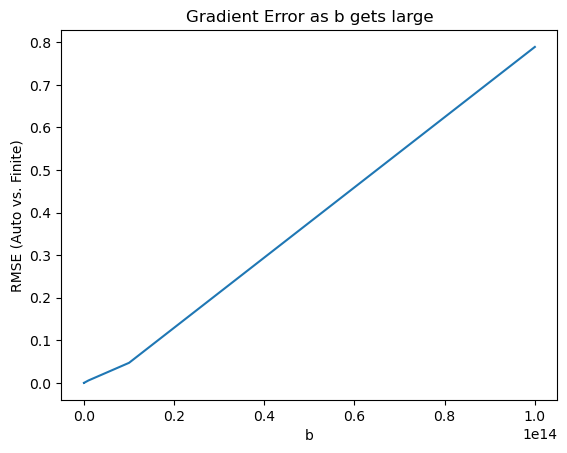

In [11]:
# Plot the RMSE between Auto and Approximated Gradients as B gets very large:

fig, ax = plt.subplots()
ax.plot(b_bin, error_bin)
ax.set_xlabel("b")
ax.set_ylabel("RMSE (Auto vs. Finite)")
ax.set_title("Gradient Error as b gets large")
plt.show()

__Comment:__ When plotting the RMSE between autograd and finite-differences for an increasingly large Rosenbrock parameter, __b__, it appears that the RMSE grows without bound as $b \rightarrow \infty$. This is because, when $x_{i} \neq$ 0 or 1, as is likely the case in a uniformly sampled interval between [0,1], the gradient (and the second-order derivative) of the rosenbrock begins to explode as b gets very large. In other words, __b__ can be thought of a kind of curvature parameter, where a large __b__ can simoultaneously increase the length of the flat valley and the steepness of its surrounding walls. In the case of extreme curvature, it becomes more difficult to approximate the slope between two points as a straight line, and it will take a greater number of points and exptrapolated slopes to get a good approximation of the gradient. The autodifferentiated gradient should remain relatively accurate, as it is climbing backwards along a graph of elementary computations to calculate exact derivatives. Of course, even this methid is not immune to numerical errors; as the computational graph of the elementary operations becomes very complex, numerical errors resulting from finite precision can arise, as well. RMSE grows linearly with __b__, because we can describe the error as a linear combination of __b__, but this is only true because we squared the norm of the difference; otherwise, RMSE is concave in __b__.

1. https://arxiv.org/pdf/2101.10546.pdf

#### $\textbf{(v)}$ Of course, for Newton's method, you actually need the Hessian as well. Write a function that calculates the Hessian $D^2 L(x, \lambda)$.

In [12]:
# Define the Lagrangain Hessian function:
    # from torch.autograd.functional import hessian

def lagrange_autohess(D, a, b, r, quietly=True):
        """Input: D=[X, λ] of length m; Output: Hessian (m x m) tensor Matrix"""
        
        if isinstance(D, torch.Tensor):           
            D_tensor = D.double()      
        else:                                         
             D_tensor = tensor(D).double()   #Here, autograd.hessian does the gradients for us, but still requires floats
        
        short_lag = lambda D: lagrange(D, a, b, r)   
        hessian_matrix = hessian(short_lag, D_tensor)
        
        if quietly==False:
            print()
            print(f"-------Hessian ({hessian_matrix.size()}):-------")
            print(hessian_matrix)

        return hessian_matrix

# Test the function
a=1
b=1
r=1
D0 = [0]*6
D1 = tensor(D0)
D2 = np.array(D0)

result = lagrange_autohess(D0, a, b, r, quietly=False)


-------Hessian (torch.Size([6, 6])):-------
tensor([[2., 0., 0., 0., 0., 0.],
        [0., 4., 0., 0., 0., 0.],
        [0., 0., 4., 0., 0., 0.],
        [0., 0., 0., 4., 0., 0.],
        [0., 0., 0., 0., 2., 0.],
        [0., 0., 0., 0., 0., 0.]], dtype=torch.float64)


#### $\textbf{(vi)}$ For Newton's method on $L$, if we start at a point $y_k = (x_k, \lambda_k)$, we calculate our next iteration as: $$D^2 L(y_k) s_{k} = DL(y_k)$$ $$y_{k+1} = y_k + \alpha s_k$$ where $\alpha = 1$, and $s_{k}$ is the solution to the linear system in the first line. Write a function that calculates the search direction $s_k$ given an initial point $y_k$.

__Comment:__ To reach a unique solution for $s_{k}$ in the linear system, we need to ensure that the Hessian, $D^{2}L(y_{k})$ is non-singular (i.e. is invertable). In the test case, X=[0,0] and λ=0, we know that from the outset the Hessian is singular, so the traditional np.linalg.solve approach will not work.

First, we need a method for checking whether the Hessian is singular (non-invertable). One way to do this would be to check if its determinant equals zero. However, we may be able to employ a more numerically stable (albeit computational  expensive) check: calculating the rank of the matrix matrix via Singular Value Decomposition (SVD) and comparing it with the square dimensions. If the rank, the number of linearly-independent rows or columns is less than the respective dimension, then we know that at least one pair of the columns or vectors are linearly-dependent, and thus the Matrix singular. Some sources that delve deeper into this topic:

1. https://cims.nyu.edu/~donev/Teaching/NMI-Fall2014/Lecture-SVD.handout.pdf
2. https://mathematica.stackexchange.com/questions/20379/eigenvalues-and-determinant-of-a-large-matrix#:~:text=Eigenvalue%20computation%20for%20exact%20matrices%20is%20much%20worse%2C,singular%2C%20you%27ve%20probably%20got%20eigenvalues%20far%20from%20zero
3. https://pillowlab.princeton.edu/teaching/statneuro2018/slides/notes02_SVD.pdf 
4. https://stackoverflow.com/questions/17931613/how-to-decide-a-whether-a-matrix-is-singular-in-python-numpy

In [13]:
# Define function that checks if matrix is invertable
    # from np.linalg import matrix_rank
def is_singular(M):
    if matrix_rank(M) < min(M.shape):   #Calculates the rank of a matrix, the number of linearly-independent rows or columns in the matrix.
        return True                     #Singular if there are any linearly-dependent rows or columns
    else: 
        return False
    
# Test the function:
a=1
b=1
r=1
D0=[0]*3
D1=[0,1,0]

nonsingular_matrix = lagrange_autohess(D1,a,b,r)
singular_matrix = lagrange_autohess(D0, a,b,r)

print(is_singular(nonsingular_matrix))
print(is_singular(singular_matrix))

False
True


Next, we need to initiate a solving routine that side-steps matrix inversion. One possibility is using a least-squares approximation: np.linalg.listsq approximates x in the system Ax=b by minimizing the norm ||b-ax||. Alternatively, we could try to "dampen" or regularize the Hessian, and add a small constant to the diagonal, the set of "pure" second-order partial derivatives, to make it invertable. Finally, we could try to perturb, or add a small amount of noise to X to make it singular.

We informally tested these methods with the performance of the simple_example function, and found that, in this context, dampening the Hessian did not perform as well as perturbation. Adding a small amount of noise to D=[X,λ] to make it non-singular lead to faster computation and greater consistency in the convergence of the optimization algorithm.

One possible explanation might be that, although you are adding noise to the optimization problem if the Hessian is singular, you quickly catch yourself on an optimization path that does not require adding more noise. This is because, in $R^{nxn}$, non-singular matrices far outnumber singular ones, so ___eventually___ landing on a non-singular matrix is guaranteed. 

1. https://en.wikipedia.org/wiki/Invertible_matrix): "Over the field of real numbers, the set of singular n-by-n matrices, considered as a subset of ${R} ^{n\times n}$ is a null set, that is, has __Lebesgue measure zero__. This is true because singular matrices are the roots of the determinant function. This is a continuous function because it is a polynomial in the entries of the matrix. Thus in the language of measure theory, almost all n-by-n matrices are invertible."

It is also interesting to note that a uniform perturbation (that is, random noise sample from a uniform distribution [0,1]) applied separately to each element lead to better performance than normal distribution centered at 0.5 or a beta distribution biased towards 0, as well as very small perturbations applied only to one element. Perhaps these perurbations led to some form of systematic bias in the optimization path or made the Hessian more poorly-conditioned. 

In [14]:
# Define the Newton Search Vector

def search_direction(y_k, a, b, r):
    '''Input: yk=[X, λ] of length m; Output: Search Vector (m x 1)-- i.e., direction of next step'''
    
    yk_float = [float(item) for item in y_k]    #Here we manually iterate over y_k and convert each element to a float
    yk_tensor = torch.tensor(yk_float)
    
    gradient = lagrange_autograd(yk_tensor,a,b,r)
    hessian_matrix = lagrange_autohess(yk_tensor,a,b,r)
    
    while is_singular(hessian_matrix)==True:          #Check if Hessian is a Singular Matrix
        yk_new = yk_tensor + torch.rand_like(yk_tensor)      #Perturb the singular matrix until it is non-singular
        hessian_matrix = lagrange_autohess(yk_new,a,b,r)  
        if is_singular(hessian_matrix)==False:    
            break

    s_k = solve(hessian_matrix, gradient)    #ax=b. solve(a,b) --> x
    sk_tensor = torch.tensor(s_k)    #Convert to tensor so we can calculate yk_plus in the next step
    
    return sk_tensor

D0 = [0]*6
result = search_direction(D0, a, b, r)
result

tensor([ 1.2071, -0.5259, -1.9864, -0.0095,  0.7095,  1.1695],
       dtype=torch.float64)

It is also interesting to point out that the search_direction function is now using a manual for loop iteration for ensuring that the input is a float tensor. For some reason, using this method over the isinstance() check that appears in the previous functions is *crucial* for the convergence of algorithm, but __only__ in the context of the search_direction function. That is, the convergence of the algorithm is unaffected by one or the other method in the other functions. A potential explanation for this eludes us at this moment.

#### $\textbf{(vii)}$ For now, we'll just use regular Newton's method. Write a function that puts this all together to take in $y_k$ and output the next step in Newton's method $y_{k+1}$.

In [15]:
# Define the Newton step-rule

def single_step(yk, φ, a, b, r):
    '''alpha renamed to φ for readability; input: yk=[X, λ] (array,list,or tensor); Output: new position after step (Tensor)'''

    if isinstance(yk, torch.Tensor):           
        yk_tensor = yk.double()             
    else:                                         
        yk_tensor = tensor(yk).double()   #We continue this check to make sure we are not double-calling the tensor() method, as in the  
        
    sk = search_direction(yk_tensor, a, b, r)
    yk_plus = yk_tensor - φ*sk
    
    return yk_plus.detach()


# Test the function
a=1
b=1
r=1
φ=1
yk0 = [0]*6

result = single_step(yk0, φ, a, b, r)
result

tensor([ 0.8530,  2.1813,  0.2622, -0.3965, -1.4015, -1.3411],
       dtype=torch.float64)

#### $(viii)$ Finally, we need to choose a stopping criterion. Since this is a root finding problem, a natural way to choose when to stop is when $DL(y)$ is sufficiently small. Write a function that checks for convergence by computing the norm of the gradient $||DL(y)||_2$. For any given tolerance $\epsilon$, return true if $||DL(y)||_2 < \epsilon$, and false otherwise.

In [16]:
# Define stopping criterion

def convergence(y, ε, a, b, r, quietly=True):
    '''Input: y=[X, λ] (array,list,or tensor); Output: Bool'''  
    
    if isinstance(y, torch.Tensor):           
        y_tensor = y.double()             
    else:                                         
        y_tensor = tensor(y).double()
   
    gradient = lagrange_autograd(y_tensor,a,b,r)
    norm_gradient = torch.norm(gradient)**2     #Scalar
        
    if quietly==False:
        print("Normed Gradient: ", norm_gradient)
        print("Converged:")
        
    if norm_gradient < ε:
        return True
    else:
        return False
    
# Test the function
a=1
b=1
r=1
ε=0.5
y0 = [0]*6
y1 = tensor(y0)
y2 = np.array(y0)

gradient = lagrange_autograd(y0,a,b,r)
norm_gradient = torch.norm(gradient)
result = convergence(y1, ε, a, b, r, quietly=True)

print(f"Is (Norm of the gradient = {norm_gradient}) < (ε = {ε})?")
print(result)

Is (Norm of the gradient = 4.123105625617661) < (ε = 0.5)?
False


#### (ix) Let's try it out for a simple example. Set $n = 2$, $a = b = 1$, and $r = 2$. Start with $x_0 = (0, 0)$ and $\lambda_0 = 0$. Make a plot showing the progress of the algorithm (plot the values of $x_k$ at each step, the constraint set, and the contours of $f$). Use a tolerance of $\epsilon = 10^{-6}$. How is the algorithm doing?

In [124]:
# Define function that optimizes the simple example: constrained minimization of Rosenbrock given r=2 

def simple_example(D0, ε, φ, a, b, r, itermax=200, quietly=True):
    qe.tic()
    D = D0
    prev_D = D0
    D_bin = []
    num_iter = 0 
    
    while convergence(D, ε, a, b, r)==False:
        D = single_step(D, φ, a, b, r)
        if (convergence(D, ε, a, b, r)==True) or (num_iter > itermax):
            break
        if torch.isnan(D).any():  # Check for NaN values in D
            D = prev_D             #Revert to previous non-NaN tensor
            break
        prev_D = D
        D_bin.append(D.detach())
        num_iter += 1
    
    if quietly==False:
        rosen_val = rosenbrock(D[:-1],a,b).detach().item()
        print()
        print("-----Minimize Rosenbrock: Summary-----")
        print("Rosenbrock Min: ", rosen_val)
        print("Iterations: ", num_iter)
        print("Argmin (X): ", np.array(D[:-1].detach()))
        print("Argmin (λ): ", np.array(D[-1].detach()))
        
        if rosen_val < ε:
            print("Global Minimum: Success")
        else:
            print("Global Minimum: Failed")
           
    qe.toc()
    return D_bin


#Test the function
a = 1
b = 1
r = 2 
ε = 10**(-6)
φ = 1
λ0 = 0
D0 = [0,0,λ0]

result = simple_example(D0, ε, φ, a, b, r, quietly=False)


-----Minimize Rosenbrock: Summary-----
Rosenbrock Min:  2.650777459051224
Iterations:  9
Argmin (X):  [ 0.34541271 -1.37142576]
Argmin (λ):  1.0868388344260724
Global Minimum: Failed
TOC: Elapsed: 0:00:0.04


In [137]:
# Plot the performance of the simple_example algorithm
    #import matplotlib.color as mcolors

def plot_optimizer(result, a,b,r,buffer=0.75, centered=True):
    '''Where result is an array containing the X at each step, and the buffer is a positive value that constrols the margins
    between the plot frame and the algorithm's path-- i.e., how "zoomed out" the plotting window is from the path'''
    
    x1 = []
    x2 = []
    for i in result:
        x1.append(i[0].item())      #Separates the X1,X2 values for each step
        x2.append(i[1].item())   
    
    # Generate the graphing window
    max_x1 = max(x1)
    min_x1 = min(x1)
    max_x2 = max(x2)
    min_x2 = min(x2)
    x1_buffer = np.ptp(x1)*buffer
    x2_buffer = np.ptp(x2)*buffer
     
    if centered==False:     #i.e., centered at zero: we want to see more than a focus on the optimization path
        x = np.linspace(min_x1 - x1_buffer, max_x1 + x1_buffer, 100)
        y = np.linspace(min_x2 - x2_buffer, max_x2 + x2_buffer, 100)
        [X, Y] = np.meshgrid(x, y)
        Z = rosenbrock([X, Y],a,b)
        norm = mcolors.PowerNorm(gamma=0.5, vmin=Z.min(), vmax=Z.max())
    else:                   #Alternatively, we can zoom onto the optimization path
        x = np.linspace(-min_x1 - 3*x1_buffer, max_x1 + 3*x1_buffer, 100)
        y = np.linspace(-min_x2 - 3*x2_buffer, max_x2 + 3*x2_buffer, 100)
        [X, Y] = np.meshgrid(x, y)
        Z = rosenbrock([X, Y],a,b)
        norm = mcolors.PowerNorm(gamma=0.3, vmin=Z.min(), vmax=Z.max())
        
    # Generate rosenbrock and constraint contours (a=b=1, r=2)
    C = constraint([X, Y],r)
    
    # Plot contours
    fig, ax = plt.subplots()
    c = ax.contour(X, Y, C, levels=3, colors='black', alpha=0.4, linewidths=2)
    z = ax.contourf(X, Y, Z, levels=500, cmap='jet', norm=norm)
    fig.colorbar(z)
    
    # Add line path on top of the contour plot
    ax.plot(x1, x2, 'r-', linewidth=2)    #Plot lines
    plt.scatter(x1, x2, s=30, c='r')      #Enlarge points connecting lines
    ax.text(x1[0], x2[0], 'Start', color='black', fontsize=13, fontweight="bold")       #Label start point
    ax.text(x1[-1], x2[-1], 'End', color='yellow', fontsize=13, fontweight="bold")   #Label end point

    # Set the title and labels for the plot
    ax.set_title('Rosenbrock (Colored) Optimization with Constraint (Black Levels)')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    
    # Display the plot
    return plt.show()

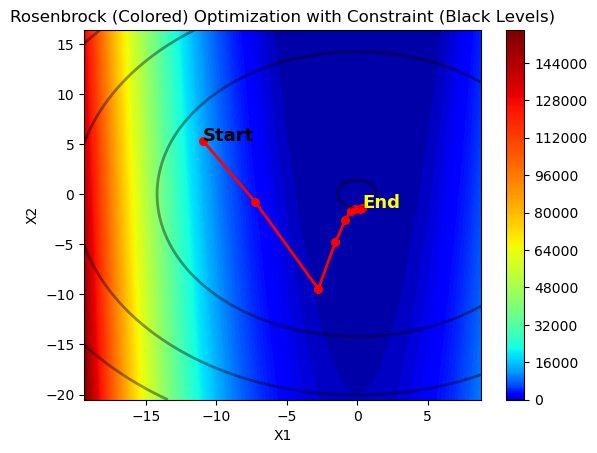

In [138]:
# Plot the simple_example: 
plot_optimizer(result,a,b,r, centered=False)

####  (x) Now, let's put it all together. Write a function that solves for the constrained optimum of eq. (1). It should take as inputs: the parameters $a$ and $b$, the dimension $n$, an initial value, as well as a tolerance parameter (to control when to stop). It should return:
   - **the function value of $f$ at the optimum you find**
   - **the value of $x$ that attains the minimum**
   - **(for diagnostic purposes) the Lagrange multiplier $\lambda$**
   - **the number of Newton steps you took,**
   - **the norm of $DL$ when you stopped, and**
   - **how badly you're deviating from the constraint**

-----Minimize Rosenbrock: Summary-----
Rosenbrock min:  tensor(3.2653e-05, dtype=torch.float64, grad_fn=<AddBackward0>)
Argmin (X):  [1.00204188 0.99875092]
Argmin (λ):  -0.002326622694379027
Final Gradient Norm:  0.06155186626766982
Constraint Deviation:  0.001596727399929776
Iterations:  5
Time Elapsed (s):  0.0247


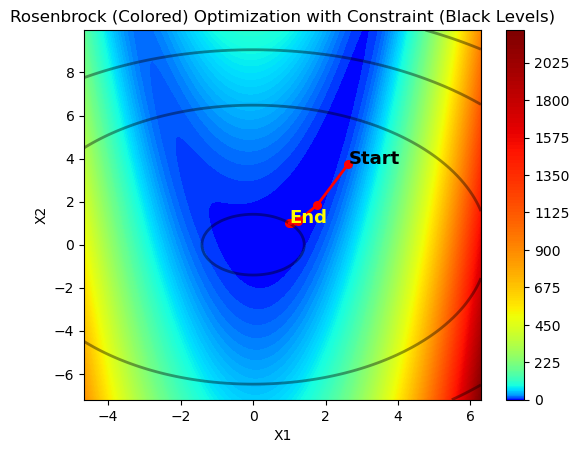

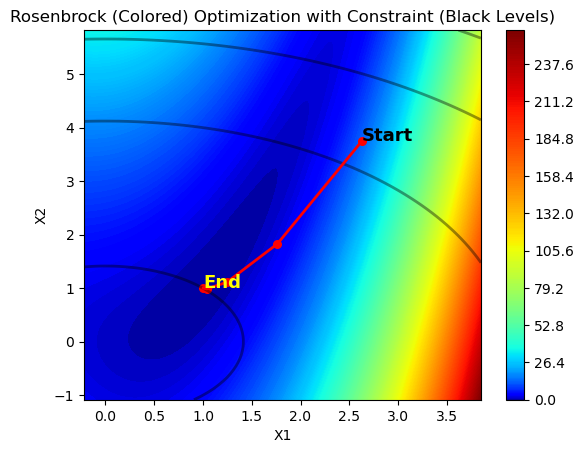

In [140]:
# Sequential Quadradic Programming Algorithm: Constrained Optimimum of the Rosenbrock Function

def SQP(X0, ε, a, b, r, itermax=200, quietly=True):
    qe.tic()
    X = X0
    prev_X = X0
    X_bin = []
    num_iter = 0 
    
    while convergence(X, ε, a, b, r)==False:
        X = single_step(X, φ, a, b, r)
        if (convergence(X, ε, a, b, r)==True) or (num_iter > itermax):
            break
        if torch.isnan(X).any():  # Check for NaN values in D
            X = prev_X  # Revert to previous non-NaN tensor
            break
        prev_X = X
        X_bin.append(X.detach())
        num_iter += 1
        
        rosen_val = rosenbrock(X[:-1],a,b)    #Kind of inefficient to recalculate all these metrics at every iteration
        argmin_X = np.array(X[:-1].detach())            
        argmin_λ = X[-1].detach().item()
        gradient = lagrange_autograd(X,a,b,r)          #Might be able to use a separate while loop function or generator to return the final X and calculate the metrics once.  
        final_grad = torch.norm(gradient).item()
        cons_dev = abs(constraint(X,r)).detach().item()
        time_elap = np.round(qe.toc(verbose=False),4)
    
    if quietly==False:
        
        print("-----Minimize Rosenbrock: Summary-----")
        print("Rosenbrock min: ", rosen_val)
        print("Argmin (X): ", argmin_X)
        print("Argmin (λ): ", argmin_λ)
        print("Final Gradient Norm: ", final_grad)
        print("Constraint Deviation: ", cons_dev)
        print("Iterations: ", num_iter)
        print("Time Elapsed (s): ",time_elap)
    
    return X_bin, rosen_val, argmin_X, argmin_λ, final_grad, cons_dev, num_iter, time_elap

# Test the function
a=1
b=1
r=2
λ0 = 0
X0 = [0, 0,λ0]
ε = 1e-7

result = SQP(X0, ε, a, b, r, quietly=False)

#Plot the optimization path
plot_optimizer(result[0],a,b,r, centered=True)
plot_optimizer(result[0],a,b,r, centered=False)

#### (xi) Keep $r = 2$, and move around your initial starting point $x_0$. How sensitive are your results to the initial guess? We know that in this case, the true minimum is at $x$ such that $x_i = 1$ for all $i$. How close do you need to make $x_0$ to the true minimum to ensure convergence?

In [142]:
# Sensitivity analysis of the SQP algorithm: Initial Starting Point

# Generate performance data for a grid of initial points: (-5, 5) x (-5, 5)
a=1
b=1
r=2
ε=1e-6
λ0=0
k = 7         #Number of grid points = k^2
bounds = 5    #Plotting window: (x,y) = ([-bounds,bounds],[-bounds,bounds])

x1_bin = []
x2_bin = []
rosen_bin = []
argX_bin = []
argλ_bin = []
grad_bin = []
cons_bin = []
iter_bin = []
time_bin = []
dev_bin = []
run = 0 
te = []

qe.tic()
for i in np.linspace(-bounds,bounds,k):
    for j in np.linspace(-bounds,bounds,k):
        result = SQP([i,j]+[λ0], ε, a, b, r, quietly=True)
        x1_bin.append(i)
        x2_bin.append(j)
        rosen_bin.append(result[1].detach())
        argX_bin.append(result[2])
        argλ_bin.append(result[3])
        grad_bin.append(result[4])
        cons_bin.append(result[5])
        iter_bin.append(result[6])
        time_bin.append(result[7])
        run += 1
        print(f"Run: {run}", end="\r", flush=True)  # Prints the run being calculated, in-place
qe.toc()   

TOC: Elapsed: 0:00:0.03


0.039853572845458984

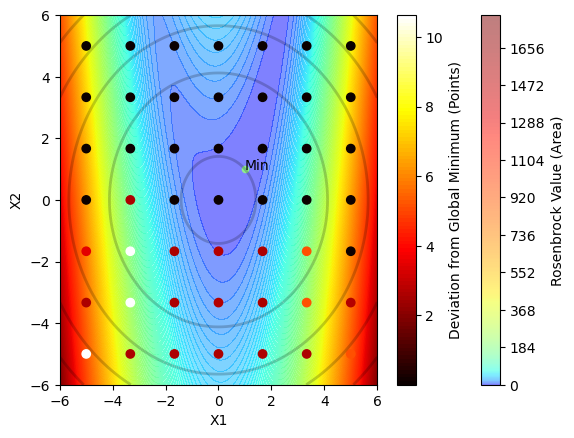

In [143]:
# Define a function that plots a given performance metric for each starting point in the grid:

def sensitivity_plot(metric, metric_name):
    '''Input: performance metric list from the data generating process above; output: colored scatter plot'''
    # Generate domain
    buffer=1
    x = np.linspace(-bounds-buffer,bounds+buffer,100)
    y = np.linspace(-bounds-buffer,bounds+buffer,100)
    [X, Y] = np.meshgrid(x, y)
    
    # Generate rosenbrock and constraint contours (a=b=1, r=2)
    Z = rosenbrock([X, Y],a=1,b=1)
    C = constraint([X, Y],r=2)
    
    # Plot contours
    fig, ax = plt.subplots()
    norm = mcolors.PowerNorm(gamma=0.3, vmin=Z.min(), vmax=Z.max())
    c = ax.contour(X, Y, C, levels=4, colors='black', alpha=0.2, linewidths=2)
    z = ax.contourf(X, Y, Z, levels=500, cmap='jet', alpha=0.5, norm=norm)
    
    cbar1 = fig.colorbar(z)
    cbar1.set_label('Rosenbrock Value (Area)')
    
    # Plot the color map corresponding to the initial starting points
    sc = ax.scatter(x1_bin, x2_bin, c=metric, cmap=plt.cm.get_cmap('hot',100))  #Plot the starting points, and their eventual deviation (color)
    cbar2 = fig.colorbar(sc)
    str_metric = metric
    cbar2.set_label(f'{metric_name} (Points)')
    
    ax.scatter(1,1, color="lightgreen", s=20)  #True minimum
    ax.text(1,1, 'Min', color='black', fontsize=10) 

    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    
    return plt.show()


sensitivity_plot(rosen_bin, "Deviation from Global Minimum")


__Comment:__ In this plot, each colored point represents a starting point in the range of (-5, 5) x (-5, 5) and its color represents the value of the Rosenbrock function in the final iteration of the algorithm (i.e. the deviation of the found solution from 0, the true minimum). The color of the area represents the value of the true rosenbrock function and rapid changes in color represent large gradients of the function. The black rings represent the unit circles on which X1,X2 are constrained depending on r. With r=N, the constraint is non-binding; that is, the true Min lies on the circle. 

As the starting points get closer to the curved apex of the Rosenbrock Valley (towards the -X2 direction), the converged deviation from the true global minimum increases. Here, relatively weak gradient signals make it more difficult to converge within a given tolerance-- the algorithm gets trapped in the plateau. Interestingly, increasing __b__ elongates the flat valley and steepens the the surrounding walls, making convergence even more difficult: the algorithm is catapulted into the narrow valley and then left to search for the minimum in the dark.

1.https://www.scirp.org/journal/paperinformation.aspx?paperid=96749
2.https://arxiv.org/pdf/2101.10546.pdf

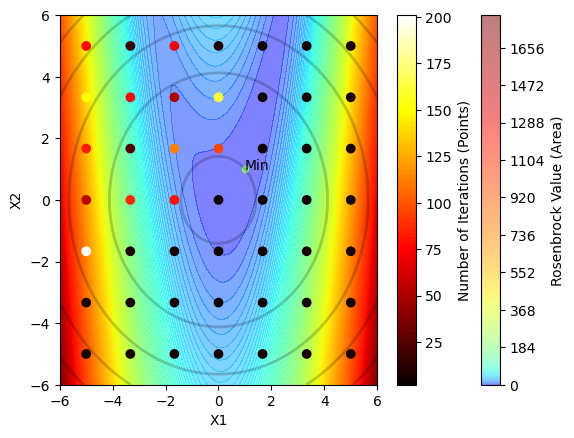

In [144]:
sensitivity_plot(iter_bin, "Number of Iterations")

__Comment:__ The initial starting points also appear to impact the number of iterations until convergence, particularly in the flatter regions around the valley bend of the true minimum. One possible explanation is that the algorithm would rather trudge through flatter regions (with a greater number of iterations) than pursue even a slightly positive gradient.

#### (xii) Try out your function for a variety of parameters and report the results. How is the algorithm doing?

__Comment__: We conduct 2 more simulations to understand how the dimensionality of the Rosenbrock domain impacts the performance of the algorithm, and to highlight how similar simulations could be done for parameters a,b, and r. For now, we will comment on the impact of a,b, and r in a more anecdotal manner. 

In [145]:
# Simulation: SQP performance for random dimensionality (N):

runs = 100        #Number of simulation runs
a=1
b=1
ε=1e-3 

rosen_bin = []
argX_bin = []
argλ_bin = []
grad_bin = []
cons_bin = []
iter_bin = []
time_bin = []
size_bin = []

qe.tic()
for i in range(runs):

    num_elements = torch.randint(3, 20, (1,))  #Start at X=2, since D=[X,λ] we start at D=3
    size_bin.append(num_elements.item())

    random_tensor = torch.zeros(num_elements, requires_grad=False)
    
    r = num_elements           #Still confine X to the unit sphere that intersects the global minimum
    result = SQP(random_tensor,ε,a,b,r)
    
    if result[1] != 0:
        rosen_bin.append(result[1].detach().item())  #Sometimes the value is within machine precision of 0, in which case it's an int() without a graph.
    else:
        rosen_bin.append(result[1].item())
        
    argX_bin.append(result[2])
    argλ_bin.append(result[3])
    grad_bin.append(result[4])
    cons_bin.append(result[5])
    iter_bin.append(result[6])
    time_bin.append(result[7])
    

    print(f"Run: {i}", end="\r", flush=True)  # Prints the run being calculated, in-place
qe.toc()

data = {'rosen': rosen_bin,
        'argX': argX_bin,
        'argλ': argλ_bin,
        'grad': grad_bin,
        'cons': cons_bin,
        'iter': iter_bin,
        'time': time_bin,
        'size': size_bin}

df = pd.DataFrame(data)

TOC: Elapsed: 0:00:0.13


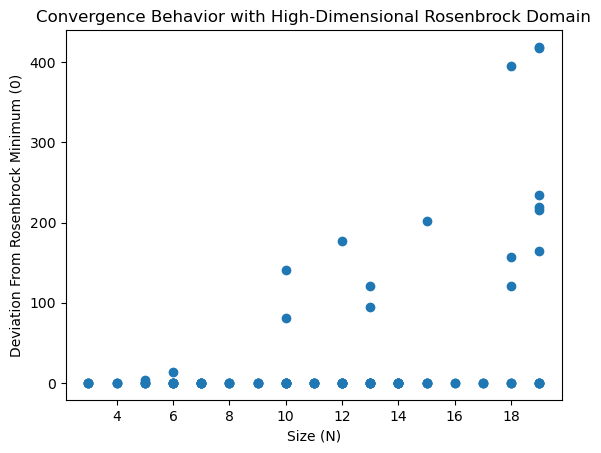

In [148]:
# Plot the value of the rosenbrock function with simulated dimensionality data:

fig,ax = plt.subplots()
x = np.array(df['size'], dtype=float)
y = np.array(df['rosen'], dtype=float)
ax.scatter(x,y)

ax.set_title("Convergence Behavior with High-Dimensional Rosenbrock Domain")
ax.set_xlabel("Size (N)")
ax.set_ylabel("Deviation From Rosenbrock Minimum (0)")

plt.show()

__Comment__: It appears that higher dimensionality is associated with a higher number of convergence failures, with the maximum magnitude of the failures increasing steeply. This may be due numerical instability or the fact that there are more "directions" or ways to get trapped in local minima. It may also reflect a greater tendency to exceed the maximum allowance of iterations (200) due locally oscillating or diverging behavior in higher dimensions.

Interestingly, a and b do not necessarily greatly impact the "hit-rate" (proportion of successful converges to a constrained global minimum) of the algorithm, although very large a, b have a spectacular impact on the magnitude of the failure when it does occurs, both in terms of the norm of the final gradient and the value of the rosenbrock function. Both exaggerate the relative steepness and flatness of the function at certain regions, and so can be thought of as a kind of curvature parameter. In the case of b=100, the Rosenbrock function attains the classic "banana"-shaped valley, with even more potential plateaus to get stuck on. At the extreme, a and b make the gradient explode or vanish at various points of the domain, which can amplify small numerical errors in the iterated inputs and intermediate computational steps (errors which are inevitable due to the finite precision of the processor), especially if those computations are done via unstable numerical routines. It may also make the algorithm more susceptible to local minima, which become more numerous and exaggerated.

Moderately large a, b may actually have a slight positive effect on the rate of convergence (decreasing the number of iterations), provided that the tolerance, ε, also increases to accomodate for the algorithm's more volatile nature, and the algorithm doesn't get stuck in a plateau right away. This is because larger a and b give the algorithm a stronger signal about first and second-order information. To make convergence even faster, one could try to incorporate momentum-based rules that allow the algorithm push through flat areas with an accumulated gradient signal. 

Increasing r, without also increasing the dimensionality (N), essentially expands the radius of the unit sphere on which the solutions are confined to. However, the negative impact on the algorithm arises less from the distance from the true global minimum (0), but rather also from an exploding gradient, particularly in the λ term. In the case of very large r, the gradient of the lagrangian is poorly-conditioned, which may lead to a greater number of constraint deviations and convergence failures. 

### (b) Penalty Method:

#### (i) Try solving the problem directly when a = b = r = 10, n = 10, and Pk = 1012. Start with x0 = 0. Use your favorite algorithm for the unconstrained problem. (Here it’s okay to use someone else’s implementation). How well does this fare? Do you converge? If you do, how long does it take (how many function evaluations)?

In [4]:
# Definition of the rosenbrock function
def f(X,N, a, b):
    Y = 0
    for i in range(N-1):
        Y += (a*((1-X[i])**2) + b*((X[i+1]-X[i]**2)**2))
    return Y

# Definition of the Constraint
def g(X, N, r):
    Y = 0
    for i in range(N):
        Y += X[i]**2
    return Y - r

# Definition of the penalty function 
def penalty(X, params):
    a, b, r, N, pk = params 
    return f(X, N, a, b) + (pk*(norm(g(X, N, r))**2))


In [5]:
# Definition of Parameters 
a = 10
b = 10
r = 10
N = 10
pk = 10**12
x0 = [0] * N
params = [a, b, r, N, pk]  

# Minimizing using L-BFGS-B method
minimize(penalty, x0, method = 'L-BFGS-B',args=(params))

      fun: 100000000000090.0
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 11
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

__Comment:__ We see that the L-BFGS-B converges in the initialization step (i.e. 1 iteration) and 11 function evaluations. However, we know that the rosenbrock minimum subject to the unit sphere of radius r=N is actually zero at $x_{i}=1$. This implies that the large $P_{k} = 10^{12}$ leads to a badly conditioned problem and numerical instability-- L-BFGS-B may be sensitive to small changes in its iterative inputs and numerical imprecisions.

#### (ii) Now try starting with P0 = 1, and solve a sequence of problems. Use the solution at k as a “warm-start” for the k + 1th problem. Set Pk+1 = 10 × Pk at each iteration. Repeat until you reach P12 = 10^12. How do your results compare? Do you converge to the true minimum? If not, try again with a better initial guess (remember, in this case you know where the true minimum is). Does it improve?

In [6]:
# Definition of parameters with an initial gues of x0 = 0
a = 10
b = 10
r = 10
N = 10
xb= [[0] * N]
pk_12 = []

# For-loop to iterate through with an increasing penalty value
for i in range(12):  
    pk_12.append(1*10**i) # Generates penalty values
    pk = pk_12[i] # Selects increasing peanalty value
    params = [a, b, r, N, pk]  
    res = minimize(penalty, xb,method = 'L-BFGS-B', args=(params))
    xb = res.x # reassiging previous solution as next guess
    print("Iteration: ", i)
    print("Constraint Deviation: ", g(xb,N,r))      
    print("Rosenbrock Value: ", res.fun)
    print()

res

Iteration:  0
Constraint Deviation:  -2.488662271815656e-07
Rosenbrock Value:  1.308540586977523e-12

Iteration:  1
Constraint Deviation:  -4.389574925767192e-09
Rosenbrock Value:  9.421471779115418e-13

Iteration:  2
Constraint Deviation:  -4.389574925767192e-09
Rosenbrock Value:  9.43881331034145e-13

Iteration:  3
Constraint Deviation:  -4.389574925767192e-09
Rosenbrock Value:  9.612228622601766e-13

Iteration:  4
Constraint Deviation:  -4.389574925767192e-09
Rosenbrock Value:  1.134638174520493e-12

Iteration:  5
Constraint Deviation:  -4.389574925767192e-09
Rosenbrock Value:  2.868791297123658e-12

Iteration:  6
Constraint Deviation:  -4.389574925767192e-09
Rosenbrock Value:  2.0210322523155305e-11

Iteration:  7
Constraint Deviation:  -4.389574925767192e-09
Rosenbrock Value:  1.9362563478347175e-10

Iteration:  8
Constraint Deviation:  -4.389574925767192e-09
Rosenbrock Value:  1.927778757386636e-09

Iteration:  9
Constraint Deviation:  -4.389574925767192e-09
Rosenbrock Value:  1.

C:\Users\Tomgo\AppData\Local\Temp\ipykernel_8544\1940883457.py:14: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res = minimize(penalty, xb,method = 'L-BFGS-B', args=(params))


      fun: 1.9268377448468996e-06
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([2244.17056461, 2244.16997803, 2244.1694198 , 2244.16997819,
       2244.16997595, 2244.16998087, 2244.17056439, 2244.17056014,
       2244.17056435, 2244.17111376])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 110
      nit: 0
     njev: 10
   status: 2
  success: False
        x: array([1.00000002, 0.99999995, 0.9999999 , 0.99999992, 0.99999993,
       0.99999999, 1.00000004, 1.00000004, 1.00000009, 1.00000013])

__Comment:__ We see that after 11 iterations, the unconstrained L-BFGS-B algorithm converges to the constrained minimum thanks to the penalties, which are growing progressively larger at every iteration. Interestingly, even when the constrained is non-binding (that is, r=N), but particularly when it is binding, we see a kind of "tug-of-war" between the final Rosenbrock value and the deviation from the constraint. The unconstrained minimization algorithm wishes to descend the function no matter the cost, even violating the constraint; meanwhile, the growing penalty makes deviations from the constraint increasignly costly. What we observe is a decreasing constraint deviation and increasing (constrained) rosenbrock value as the algorithm is pulled back towards the constraint. 

Nevertheless, the final iteration message shows "ABNORMAL_TERMINATION_IN_LNSRCH", which indicates that L-BFGS-B had trouble calcualting a search direction based on the gradient near x-- at this point the Rosenbrock function has likely become too shallow or the large penalties have lead to numerical errors in the gradient. One way we could fix this is by decreasing the tolerance of the function and gradient, and to increase the maximum number of iterations. Alternatively, we could move the initial guess closer to the known minimum, but often the true minimum is not known. 

In [7]:
# Adjusting the L-BFGS-B stopping criteria

options = {'ftol': 1e-6, 'gtol': 1e-6, 'maxiter': 1000}  

# Definition of parameters with an initial gues of x0 = 0
a = 10
b = 10
r = 10
N = 10
xb= [[0] * N]
pk_12 = []

# For-loop to iterate through with an increasing penalty value
for i in range(12):  
    pk_12.append(1*10**i) # Generates penalty values
    pk = pk_12[i] # Selects increasing peanalty value
    params = [a, b, r, N, pk]  
    res = minimize(penalty, xb,method = 'L-BFGS-B', args=(params), options=options)
    xb = res.x # reassiging previous solution as next guess
    #print("Iteration: ", i) 
    #print("Constraint Deviation: ", g(xb,N,r))      
    #print("Rosenbrock Value: ", res.fun)
    #print()  

res

C:\Users\Tomgo\AppData\Local\Temp\ipykernel_8544\4260005107.py:18: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res = minimize(penalty, xb,method = 'L-BFGS-B', args=(params), options=options)


      fun: 8.433037465126422e-06
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([336.02295899, 335.91285761, 336.03553999, 336.012057  ,
       335.9938521 , 336.01614043, 335.97648422, 335.96375302,
       335.96654366, 335.93396219])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 77
      nit: 1
     njev: 7
   status: 0
  success: True
        x: array([1.00000878, 0.99998439, 1.00001166, 1.00000661, 1.00000248,
       1.00000737, 0.9999985 , 0.99999554, 0.99999606, 0.9999886 ])

Now the L-BFGS-B has successfully fulfilled its convergence criteria without us needing to change the initial guess. 

#### (iii) Repeat with b = 1000. Does anything change?

In [8]:
# Redefining parameters 
a = 10
b = 1000
r = 10
N = 10

xb= [[0] * N]
pk_12 = []

for i in range(12):  
    pk_12.append(1*10**i) # Generates penalty values
    pk = pk_12[i] # Selects increasing peanalty value
    params = [a, b, r, N, pk]  
    res = minimize(penalty, xb,method = 'L-BFGS-B', args=(params))
    xb = res.x
res

C:\Users\Tomgo\AppData\Local\Temp\ipykernel_8544\2716037041.py:14: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res = minimize(penalty, xb,method = 'L-BFGS-B', args=(params))


      fun: 1.0000447580554571e-05
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00697906, -0.00735083, -0.00736341, -0.00771944, -0.0076749 ,
       -0.00809   , -0.00795079, -0.00874583, -0.00945836, -0.01251817])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 33
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([1.0000002 , 1.0000002 , 1.00000019, 1.00000019, 1.00000018,
       1.00000015, 1.00000009, 0.99999996, 0.99999969, 0.99999915])

__Comment__: Now, the algorithm successfully converges to a point within tolerance for larger $P_{k}$, but that point is also slightly farther away from the known true minimum. This might be because the problem has become more poorly-conditioned, particularly in the regions surrounding the flat valley, and so accumulated numerical errors trigger a given convergence criterion too early. However, the number of function evaluations has decreased by almost half, likely because the first and second-order information in the gradient signal is stronger, so L-BFGS-B is able to move more decisively across the domain.

#### (iv) What about with r = 1?

In [9]:
# Redefining parameters 
a = 10
b = 10
r = 1
N = 10

xb= [[0.51] * N]
pk_12 = []

for i in range(12):  
    pk_12.append(1*10**i) # Generates penalty values
    pk = pk_12[i] # Selects increasing peanalty value
    params = [a, b, r, N, pk]  
    res = minimize(penalty, xb,method = 'L-BFGS-B', args=(params))
    xb = res.x
res

C:\Users\Tomgo\AppData\Local\Temp\ipykernel_8544\1972903180.py:14: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res = minimize(penalty, xb,method = 'L-BFGS-B', args=(params))


      fun: 43.76314889636613
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([330.19647478, 193.05765601, 169.27300814, 165.03955971,
       164.21524202, 163.69640088, 161.53451563, 149.68219596,
        88.52413278, -19.44752341])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 154
      nit: 1
     njev: 14
   status: 0
  success: True
        x: array([0.40548267, 0.34272549, 0.33009912, 0.32777873, 0.32732421,
       0.32703765, 0.32583945, 0.31915395, 0.28073474, 0.02795301])

Now that the constraint is binding (r=/=N), we see that the growing penalty forces L-BFGS-B away from the usual $x_{i}=1$ solution. We can test by how much our constraint is violated in using the following method:

In [10]:
# Testing by how much our constraint is violated by
g(res.x, N, r)

-1.9278624252550003e-09

We see that the amount by which are constraint is violated by is extremly small (thanks to the large penalty) which indicates that the found solution succesfully imposes the constraint on our minimization problem.

### (c) Augmented Lagrangian:

#### (i) Start with P0 = 1 and α = 10. Use a = b = r = 10 and n = 10. Guess x0 = 0, use your favorite algorithm for the inner unconstrained problem, and iterate until ||λk+1 − λk||2 < 10−8. Report your results.

In [11]:
# Defining our Augmented Lagrangian function 
def augmented(X, params):
    a, b, r, N, pk, λ = params 
    g_value = g(X,N,r)
    return f(X, N, a, b) + ((pk/2)*(norm(g_value)**2)) + (λ*g_value)

# Defining parameters
a = 10
b = 10
r = 10
N = 10
pk = 1
x0 = [0] * N
λ_k = 0 # Starting guess for lambda
params = [a, b, r, N, pk, λ_k]
tol = 1e-2 # Error tolerance in the iterated lambda

# While loop to minimize the Rosenbrock subject to the constraints
while True:
    # Solve the inner problem
    res = minimize(augmented, x0, args=(params), method="L-BFGS-B")
    x_k = res.x
    g_x = g(x_k, N, r)
    λ_kp1 = λ_k + (g_x) * pk
    if norm(λ_kp1 - λ_k)**2 < tol:
        break
    pk *= 10
    x0 = x_k
    λ_k = λ_kp1
    print(pk)
print(x_k)
print(pk)

[1.00000026 1.0000002  0.99999996 0.99999986 0.99999964 0.99999977
 0.99999995 1.00000011 1.0000001  0.99999983]
1


When the consstraint is not binding (r=N) we converge to the correct answer immediately, as shown with a $P_{k} = P_{0} = 1$. That is, we do not need to increase the penalty term to converge to the correct solution. However, it does appear that this convergence behavior is extremely fragile. In fact, the $P_{k} \rightarrow \infty$ if r lies outside of the range {9.62,10.42} or the starting guess $\lambda_{0}$ is any value greater than 0.14. This holds true even if the step-size increases: the algorithm still diverges, just more slowly.

We tried to troubleshoot this problem in various ways, such as trying various values, stopping criteria, and updating rules, but ultimately could not find the root of the problem. We suspect it lies in the way $\lambda$ and its norm from its previous value updates, failing to ever trigger the convergence criterion.

#### (ii) Compare the performance of the Augmented Lagrangian to the standard Penalty Method. Try it for a variety of parameter values, and present your results in a nice way. What do you conclude from this?**

To compare the augmented lagrangian to the pentaly method we can compute minimum points for increasing values of N. We also let N = r so that we know what the true minimum is. With this information it will allow us compare our solution to the true solution for each method and compare the efficiency of each computation. In addition, we can also compare the time taken by each method.

In [12]:
# Defining the augmented lagrangian as a function
def augmented_function(x0, params, N, r, λ_k, tol):
    pk = 1
    while True:
        # Solve the inner problem
        res = minimize(augmented, x0, args=(params), method='L-BFGS-B')
        x_k = res.x
        g_x = g(x_k, N, r)
        λ_kp1 = λ_k + pk * g_x
        if λ_kp1 < tol:
            break
        if math.isinf(abs(λ_kp1)):
            break # In some cases out lagrangian tends to infinity so this will end the iteratove loop if it does
        if linalg.norm(λ_kp1 - λ_k)**2 < tol:
            break

        pk *= 10
        x0 = x_k
        λ_k = λ_kp1

    return x_k

# Generating solutions for N=1 to N=60 using the augmented lagrangian 
t = 60
N_list = []

for i in range(t):
    N_list.append(i+1)

Bin_augmented = []
qe.tic()
for i in range(t):
    a = 10
    b = 10
    r = t
    N_val = N_list[i]
    pk = 1
    x0 = [0] * N_val
    λ_k = 0
    params = [a, b, r, N_val, pk, λ_k]
    result = augmented_function(x0, params, N_val, r, λ_k, tol)
    error = ((1*t) - sum(result)) # Generating the difference between our solution and the true minimum
    Bin_augmented.append(error)
time_augmented = qe.toc()

TOC: Elapsed: 0:00:20.93


In [13]:
# Defining the penalty function 
def penalty_function(a, b, r, N, pk_list):
    x0 = [0] * N
    for pk in pk_list:
        params = [a, b, r, N, pk]
        res = minimize(penalty, x0, method='L-BFGS-B', args=(params,))
        x0 = res.x
    return res.x

# Computing the same range of values using the penalty method
pk_list = []
for i in range(12):
    pk_list.append(1*10**i)
    
Bin_penalty = []
qe.tic()
for i in range(t):
    a = 10
    b = 10
    r = t
    N = N_list[i]
    result = penalty_function(a,b, r, N, pk_list)
    error = ((1*t) - sum(result))
    Bin_penalty.append(error)
time_penalty = qe.toc() # Recording the time taken

TOC: Elapsed: 0:01:54.21


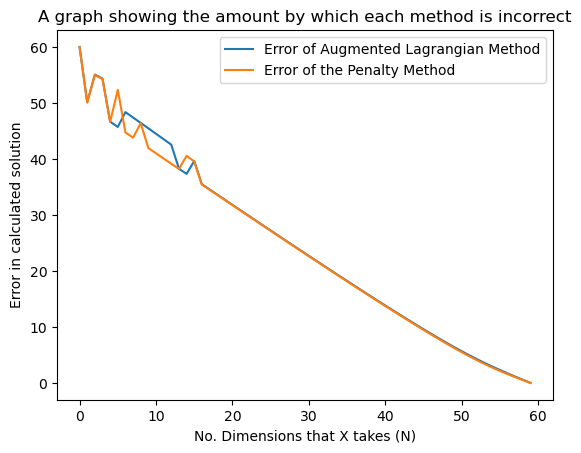

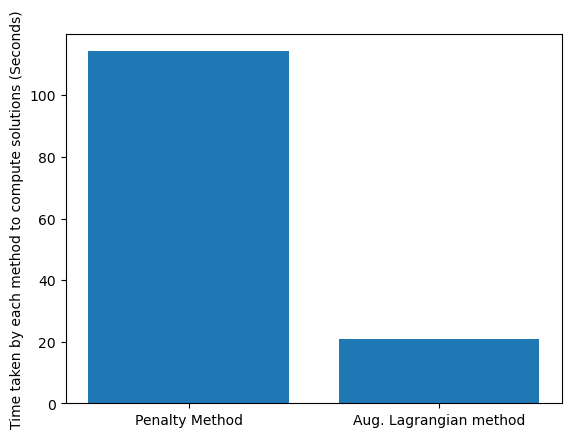

In [19]:
# Plotting the error in solution for both methods
fig, ax = plt.subplots()
ax.plot(Bin_augmented, label = 'Error of Augmented Lagrangian Method')
ax.plot(Bin_penalty, label = 'Error of the Penalty Method')
plt.xlabel('No. Dimensions that X takes (N)')
plt.ylabel('Error in calculated solution')
ax.legend()
plt.title('A graph showing the amount by which each method is incorrect')
plt.show()

# PLotting the time taken by each method to complete the above computations
x = ['Penalty Method', 'Aug. Lagrangian method']
y = [time_penalty, time_augmented]
plt.bar(x, y)
plt.ylabel('Time taken by each method to compute solutions (Seconds)')
plt.show()

The above plots show that both methods give equaly accurate solutions, however the augmented lagrangian is significantly faster. However, in our experience in completing this problem we find that the penalty method is more robust to changes in N and r.

We can also try increasing a and b for each method and seeing the amount by which the constraint is violated.

In [41]:
# Generation of an array of incraesing A and B
X = 15
A = []
B = []
for i in range(X):
    A.append(1*10**i)
    B.append(1*10**i)
    
    
# For loops to generate values for each method

Bin_penalty = []
qe.tic()
for i in range(X):
    a = A[i]
    b = B[i]
    r = 10
    N = 10
    result = penalty_function(a,b, r, N, pk_list)
    error = g(result, N, r)
    Bin_penalty.append(error)
time_penalty = qe.toc() # Recording the time taken

Bin_augmented = []
qe.tic()
for i in range(X):
    a = A[i]
    b = B[i]
    r = 10
    N_val = 10
    pk = 1
    x0 = [0] * 10
    λ_k = 0
    params = [a, b, r, N_val, pk, λ_k]
    result = augmented_function(x0, params, N_val, r, λ_k, tol)
    error = g(result,N,r)# generating the amount by which the constraint is violated by
    Bin_augmented.append(error)
time_augmented = qe.toc()

TOC: Elapsed: 0:00:1.38
TOC: Elapsed: 0:00:0.42


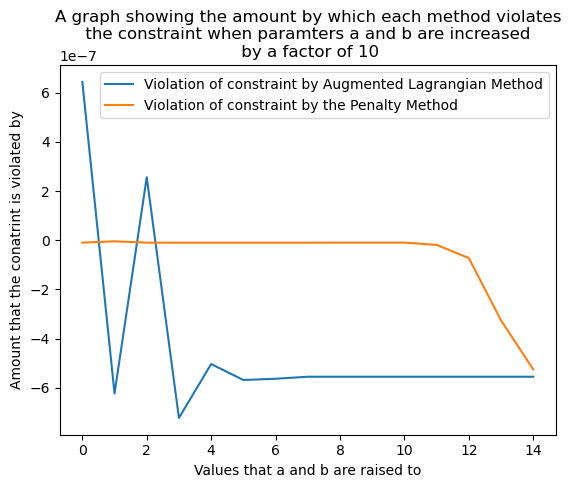

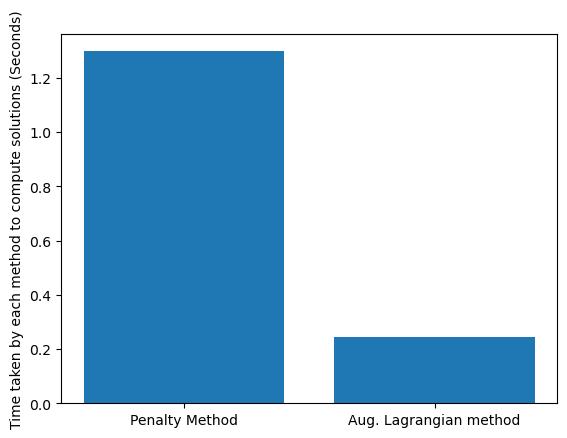

In [40]:
# Plotting the error in solution for both methods
fig, ax = plt.subplots()
ax.plot(Bin_augmented, label = 'Violation of constraint by Augmented Lagrangian Method')
ax.plot(Bin_penalty, label = 'Violation of constraint by the Penalty Method')
plt.xlabel('Values that a and b are raised to')
plt.ylabel('Amount that the conatrint is violated by')
ax.legend()
plt.title('A graph showing the amount by which each method violates\n the constraint when paramters a and b are increased \n by a factor of 10')
plt.show()

# PLotting the time taken by each method to complete the above computations
x = ['Penalty Method', 'Aug. Lagrangian method']
y = [time_penalty, time_augmented]
plt.bar(x, y)
plt.ylabel('Time taken by each method to compute solutions (Seconds)')
plt.show()

We now see that the penalty method violates the conatraint by considerably less than the augmented lagrangian, in fact for A and B up to the power of 12 we see that the violation is neglibgible in the penalty method. However, the lagrangian method still only violates the conatriaint by 6 * 10^7. We also still see the that the augmented lagrangian is faster but given that the penalty method imposes the constraint more tightly it may be better in some cases.

### (d). Parameter Transformation

In [346]:
# Rosenbrock function and the constraint, for reference:

def rosenbrock(X,a,b):
    Y=0
    for i in range(len(X)-1):     
        Y += (a*(1-X[i])**2 + b*(X[i+1]-X[i]**2)**2)
    return Y

def constraint(X,r):
    G = 0
    for i in range(len(X)):
        G += X[i]**2
    return G - r   

In [347]:
# Define the unconstrained --> constraint transformation, h: Z -- X. 

def h(Z,r):       
    '''Input: Z, vector of the transformed constraint set variables [z_1,z_2,...z_n-1]; Output: X vector of constraint set variables [x1,x2,...xn] '''
    n = len(Z) + 1
    X = np.zeros(n)
    exp_Z = np.exp(Z)
    exp_sum = np.sum(exp_Z)

    for i in range(n-1):
        X[i] = (np.exp(Z[i]) / (1 + exp_sum))**(1/2)  #if i <= n-1; Looks a lot like the softmax function
    
    X[n-1] = (1 / (1 + exp_sum))**(1/2)   #if i=n     
    
    return np.sqrt(r)*X     #We add an option to change r

In [348]:
# Now we define the inverse mapping, that translates the unconstrained Z back into our constrained X world. 
def h_inv(X):
    '''Input: X; Output: Z'''
    n = len(X)
    Z = np.zeros(n-1)
    
    for i in range(n-1):
        Z[i] = 2 * np.log(X[i] / X[n-1])
    
    return Z

#Test the functions: input should be conserved under transformation and inversion. 
r=2
x0 = [1,1]
x1 = h(x0,r)
print(x1)
h_inv(x1)  #Should equal x0

[0.91904167 0.91904167 0.55742695]


array([1., 1.])

In [349]:
# Redefine the rosenbrock in terms of Z. Unconstrained Optimization we'll be done on Z, implicitly constraining X on the normal rosenbrock.

def rosenbrock_unconstrained(Z, a, b, r):
    ''''''
    X = h(Z, r)
    return rosenbrock(X, a, b)

# Test the function:

a=1
b=1
r=2

Z0 = [0]
X0 = rosenbrock_unconstrained(Z0,a,b,2)
print(X0)
print(h(Z0,r)) #At X1,X2=1 or Z=0, the rosenbrock function is minimized (assuming r=2)

9.860761315262648e-32
[1. 1.]


In [350]:
# Minimize the unconstrained rosenbrock (in terms of Z): constraint is nonbinding

a=1
b=1
r=2
Z0 = [5]       #Initial guess

result = minimize(rosenbrock_unconstrained, Z0, args=(a,b,r))

print(result)
print("------------------------------------------")
print(f"When z = {np.round(result.x[0],7)} → X = {h(result.x,r)}, the Rosenbrock function takes on a minimum of {result.fun}")

      fun: 2.7462178344119002e-14
 hess_inv: array([[0.80094789]])
      jac: array([-2.52708604e-07])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 4
     njev: 10
   status: 0
  success: True
        x: array([-2.09617475e-07])
------------------------------------------
When z = -2e-07 → X = [0.99999995 1.00000005], the Rosenbrock function takes on a minimum of 2.7462178344119002e-14


In [351]:
# Store the z-values at every iteration:

z_list = []
def store_z(z):
    z_list.append(z)

result = minimize(rosenbrock_unconstrained, Z0, args=(a,b,r), callback=store_z)  #Calls store_z() at every iteration
print(z_list)

[array([-0.10278832]), array([-0.01511484]), array([0.00016882]), array([-2.09617475e-07])]


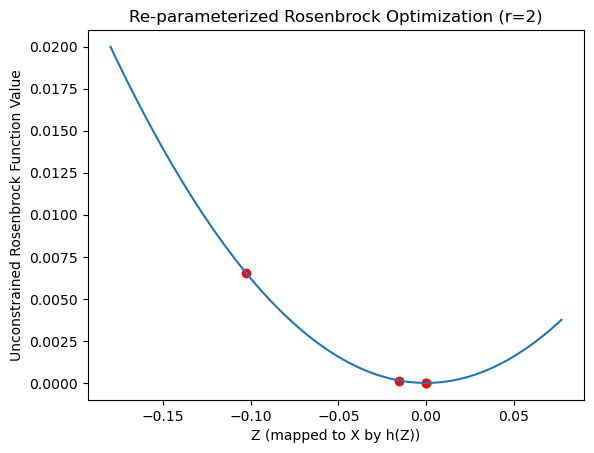

In [352]:
# Plot the re-parameterized optimization problem: Non-binding constraint (r=2)
lower_bound = min(z_list)
upper_bound = max(z_list)
buffer = np.ptp(z_list)*0.75

x=np.linspace(lower_bound-buffer,upper_bound+buffer,100)
Z_bin=[]
iter_values=[]
for i in x:
    Z_bin.append(rosenbrock_unconstrained([i],a=1,b=1,r=2))
for j in z_list:
    iter_values.append(rosenbrock_unconstrained([j],a=1,b=1,r=2))
starting_val = rosenbrock_unconstrained(Z0,a=1,b=1,r=2)
        
fig, ax = plt.subplots()
plt.plot(x,Z_bin)
ax.set_title("Re-parameterized Rosenbrock Optimization (r=2)")
ax.set_xlabel("Z (mapped to X by h(Z))")
ax.set_ylabel("Unconstrained Rosenbrock Function Value")
ax.scatter(z_list,iter_values, color="red")
#ax.scatter(Z0,starting_val, color="green")
#ax.text(Z0[0], starting_val, 'Start', color='green', fontsize=13, fontweight="bold")             #Optional, shows starting point
#ax.text(z_list[-1][0], iter_values[-1], 'End', color='crimson', fontsize=13, fontweight="bold")
plt.show()

__Comment__: Indeed, we see that the domain of the Rosenbrock function, X=[x1,x2] has been transformed into a well-behaved convex function in  terms of Z. As such, we would expect the re-parameterized algorithm to be significantly faster than the regular one. We can also test if the constraint is binding properly with r=1, which we know from the earlier version of the problem set leads to a constrained minimum at [0.80817087 0.58894809].

In [353]:
# Test the reparameterization approach with a known binding constraint (r=1)

r=1    # radius of constraint sphere, now binding
Z0 = [5]  # Initial guess

result = minimize(rosenbrock_unconstrained, Z0, args=(a,b,r))

print(result)
print("------------------------------------------")
print(f"When z = {np.round(result.x[0],7)} → X = {h(result.x,r)}, the Rosenbrock function takes on a minimum of {result.fun}")

      fun: 0.040919037193920156
 hess_inv: array([[51.19537611]])
      jac: array([3.72668728e-06])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 2
     njev: 10
   status: 0
  success: True
        x: array([0.63287091])
------------------------------------------
When z = 0.6328709 → X = [0.80817087 0.58894809], the Rosenbrock function takes on a minimum of 0.040919037193920156


__Comment:__ Next, to compare the performance of the unconstrained re-parameterized approach with the simple constrained one, let's set a large radius (r=1000) to see how both methods fare in the face of a demanding constraint. 

In [354]:
# Method 1: Re-parameterization

a=1
b=1
r=1000

fev_bin = []
nit_bin = []
fun_bin = []
time_bin = []
Z0_bin = []
success_bin = []

for i in np.random.rand(100)*100:   #Random sample of Z from 0 to 1000.
    Z0_bin.append(i)
    qe.tic()
    res = minimize(rosenbrock_unconstrained, i, args=(a,b,1000), method="SLSQP")  #Use SLSQP for comparability: this is the default when you include a constraint
    time_bin.append(qe.toc(verbose=False))
    fev_bin.append(res.nfev)
    nit_bin.append(res.nit)
    fun_bin.append(res.fun)
    success_bin.append(res.success)

    data1 = {"init":Z0_bin,
        "fun": fun_bin,
        "time": time_bin,
        "iter": nit_bin,
        "eval" : fev_bin,
        "success": success_bin}

df1 = pd.DataFrame(data1)
df1

init           fun      time  iter  eval  success
0   64.926870  1.000938e+06  0.001173     1     2     True
1   41.224581  1.000938e+06  0.001000     1     2     True
2   51.496590  1.000938e+06  0.000997     1     2     True
3   20.850654  1.001000e+03  0.002990     4     8     True
4   46.366702  1.000938e+06  0.000000     1     2     True
..        ...           ...       ...   ...   ...      ...
95  47.928416  1.000938e+06  0.000997     1     2     True
96  22.286126  1.001000e+03  0.001997     4     8     True
97  75.581868  1.000938e+06  0.000000     1     2     True
98  39.781324  1.000938e+06  0.001008     1     2     True
99   3.604334  1.001000e+03  0.001987     2    13     True

[100 rows x 6 columns]

In [355]:
# Method 2: Constrained Optimization 

a=1
b=1
r=1000

fev_bin = []
nit_bin = []
fun_bin = []
time_bin = []
X0_bin = []
success_bin = []

# Specify minimizer constraint type 
cons = {'type': 'eq', 'fun': constraint, 'args': (r,)}

for i in h(np.random.rand(100)*100,r):
    X0_bin.append(i)
    qe.tic()
    res = minimize(rosenbrock, i, args=(a,b), constraints=cons, method="SLSQP")  #Default when you include a constraint
    time_bin.append(qe.toc(verbose=False))
    fev_bin.append(res.nfev)
    nit_bin.append(res.nit)
    fun_bin.append(res.fun)
    success_bin.append(res.success)

    data2 = {"init": X0_bin,
        "fun": fun_bin,
        "time": time_bin,
        "iter": nit_bin,
        "eval" : fev_bin,
        "success": success_bin}

df2 = pd.DataFrame(data2)
df2

init  fun      time  iter  eval  success
0    2.197024e-01    0  0.005944     5    13     True
1    5.072639e-18    0  0.000997     5     2    False
2    1.287005e-17    0  0.000999     5     2    False
3    9.547927e-06    0  0.005862     7    24     True
4    3.277068e-07    0  0.000000     5     2    False
..            ...  ...       ...   ...   ...      ...
96   6.541011e-04    0  0.015750     7    21     True
97   7.137453e-12    0  0.000000     5     2    False
98   1.717312e-17    0  0.000000     5     2    False
99   1.146036e-17    0  0.000000     5     2    False
100  4.575280e-21    0  0.000000     5     2    False

[101 rows x 6 columns]

In [356]:
# Comparative Statistics: Method 1 vs. Method 2

print("Method 1: Reparam Unconstrained")
print(df1.describe())
print("Success Rate: ", df1["success"].mean())
print()
print("Method 2: Original Cosntrained")
print(df2.describe())
print("Success Rate: ", df2["success"].mean())

Method 1: Reparam Unconstrained
             init           fun        time        iter        eval
count  100.000000  1.000000e+02  100.000000  100.000000  100.000000
mean    50.261794  7.309548e+05    0.000793    1.660000    4.430000
std     27.300656  4.461678e+05    0.000918    1.327411    4.903627
min      1.252490  1.001000e+03    0.000000    1.000000    2.000000
25%     27.073583  1.001000e+03    0.000000    1.000000    2.000000
50%     51.762015  1.000938e+06    0.000961    1.000000    2.000000
75%     70.408201  1.000938e+06    0.001005    2.000000    4.000000
max     98.514899  1.000938e+06    0.004139    6.000000   22.000000
Success Rate:  1.0

Method 2: Original Cosntrained
               init    fun        time        iter        eval
count  1.010000e+02  101.0  101.000000  101.000000  101.000000
mean   5.595277e-01    0.0    0.001392    5.297030    7.752475
std    3.111880e+00    0.0    0.003040    1.144942   13.604709
min    4.575280e-21    0.0    0.000000    3.000000   

In the face of large r, it seems that the first method, of reparameterizing the constraint, lead to several improvements in performance, such as in average number of iterations until convergence, avg. no. of function evaluations, but especially avg. time until convergence. This is likely due to the fact that 1) we are optimizing with respect to one less variable (in general, optimizing w.r.t n-1 dimension domain), 2) and doing this optimization along a well-behaved, convex function. Thus, SLSQP is able to utilize 1st and 2nd-order information more efficiently. 

-------------------------------------------------------------------------------------------------------------------

## Question 2. Maximum Likelihood. (50 points)

### Some Theory.

#### (a) Proof: solving these two problems is equivalent from the perspective of finding θ⋆.

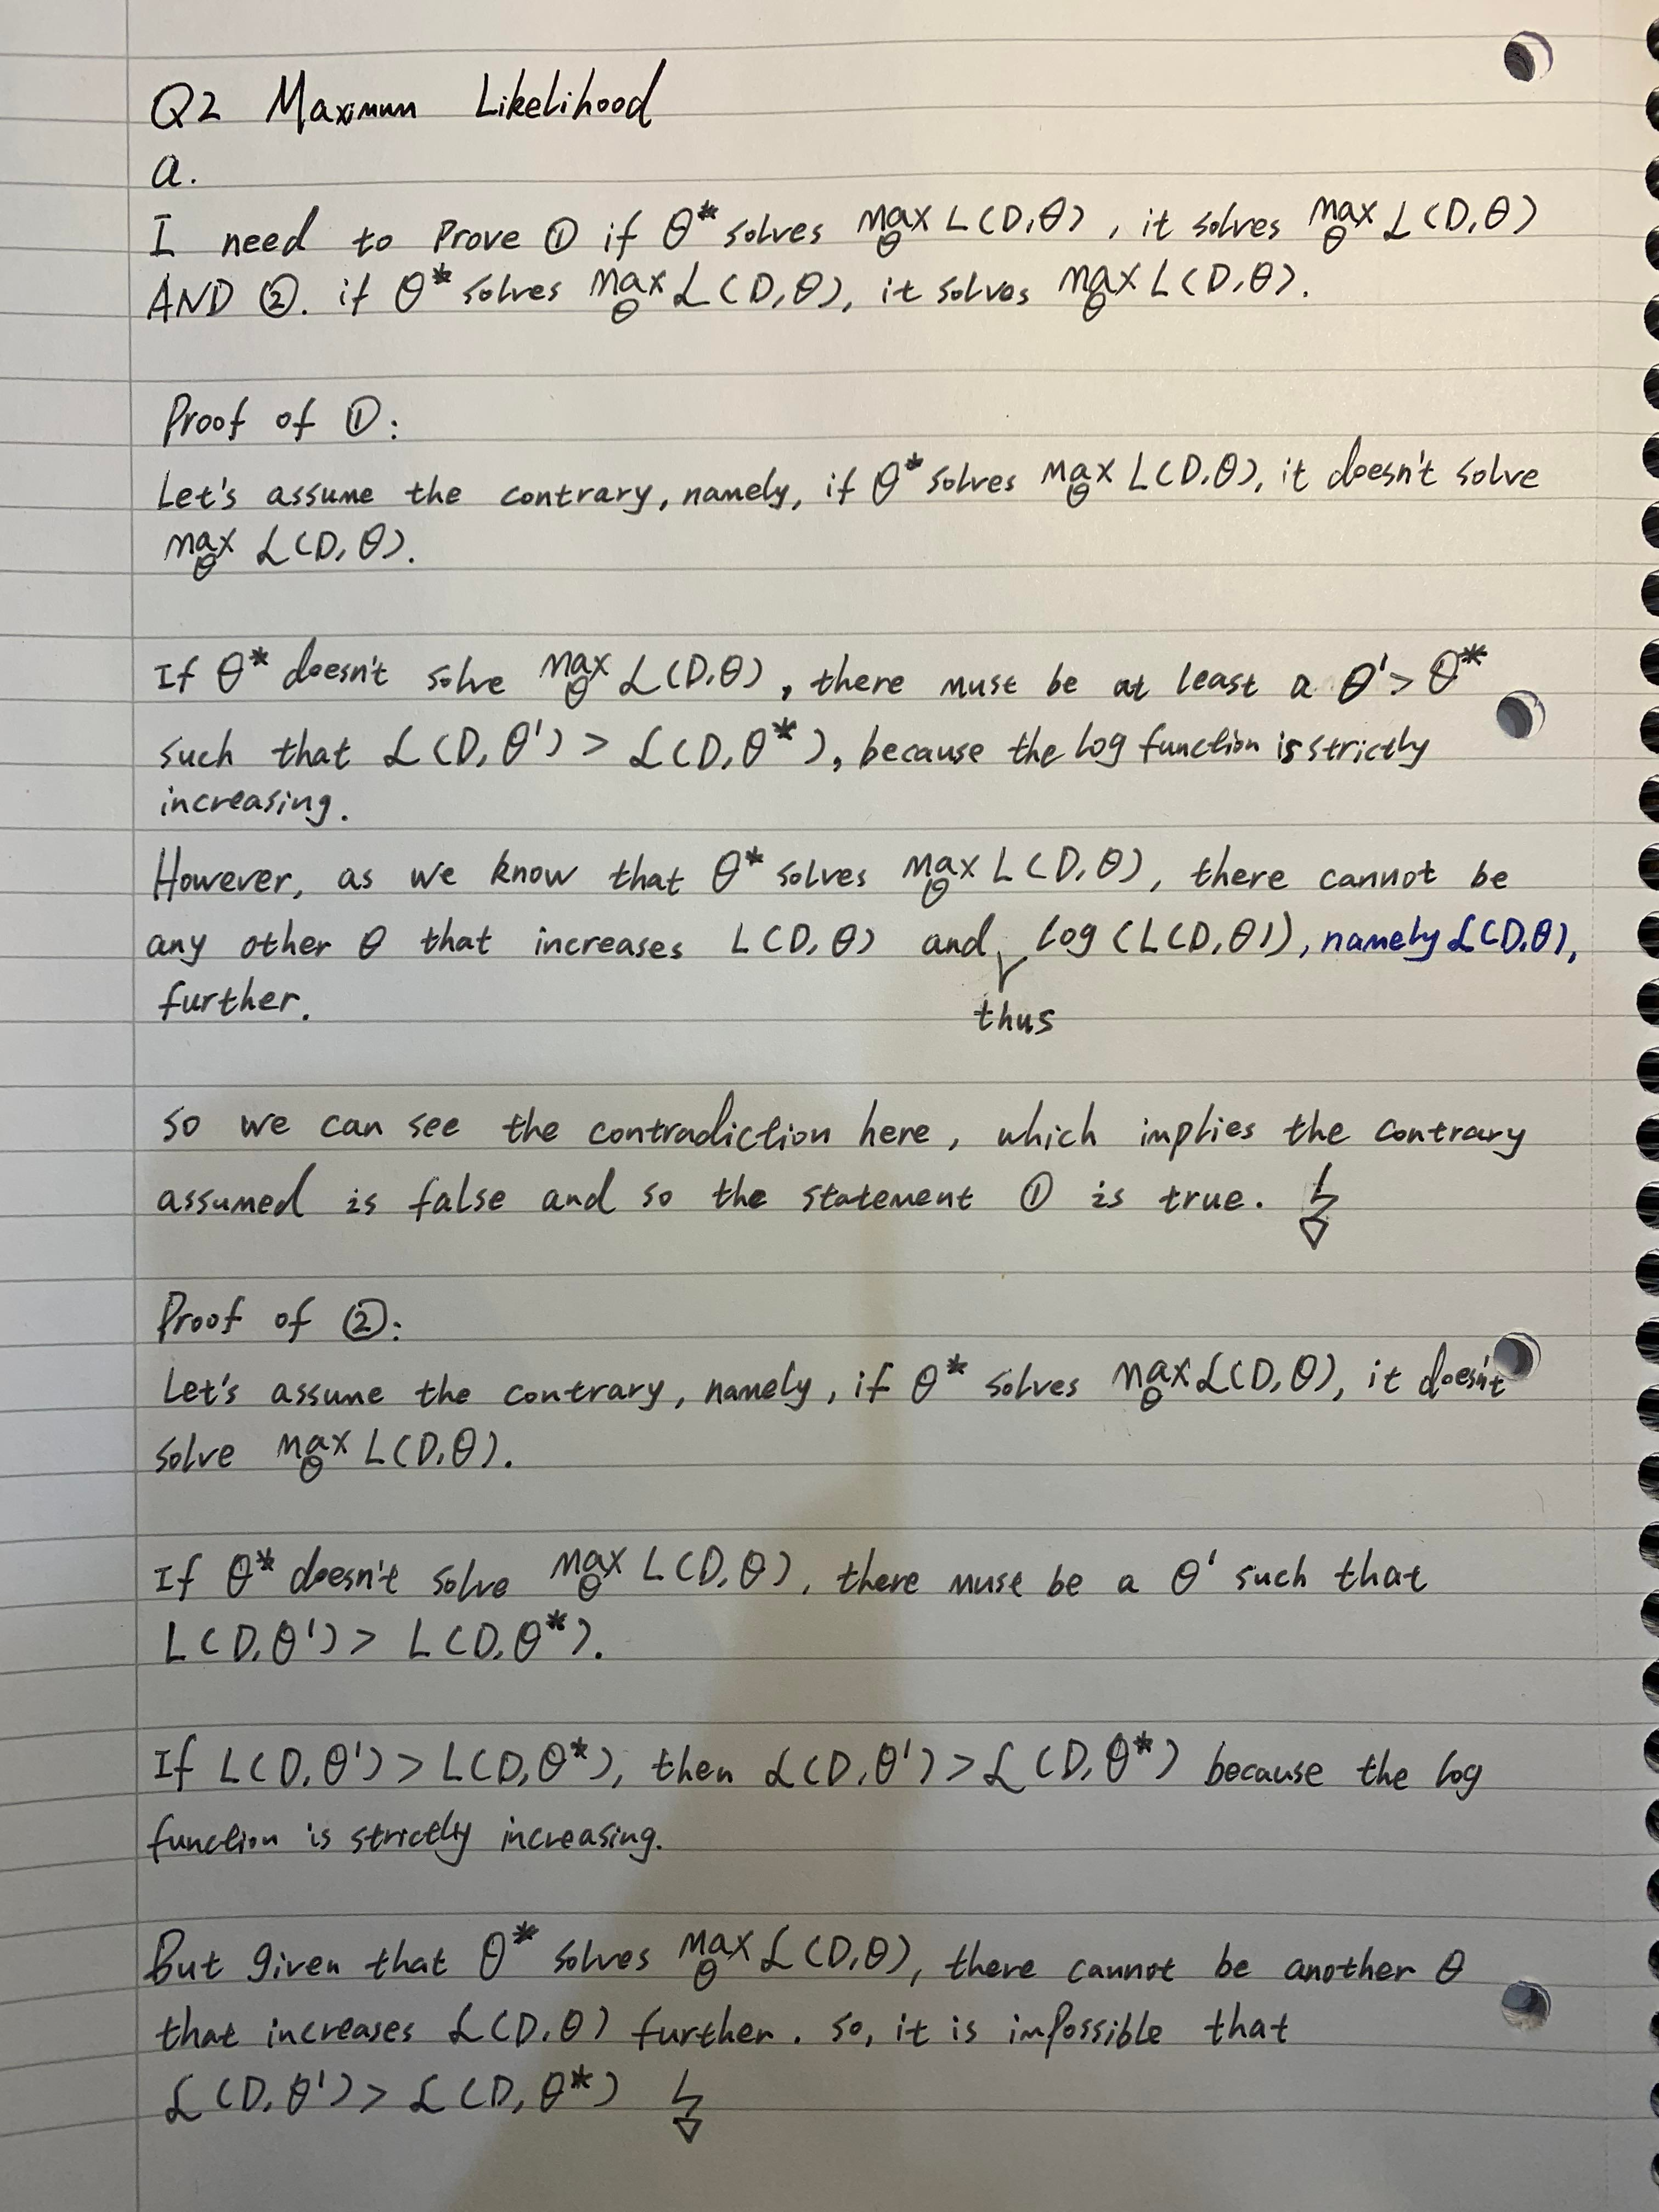

#### (b) Comment on why you might prefer to work with the log-likelihood function l instead of the regular likelihood.

The log-likelihood method might be preferred for a range of reasons. For one, it is computationally simpler, which allows the code to run faster. It also uses sums instead of products which are significantly more numerically stable since products tend to quickly converge to 0 or infinity. For the same reason, the use of sums also often results in more interpretable graphs. The additive nature of the log-likelihood may also make it much more simple to decompose contributing effects and variances and conduct sensitivity analysis. However, most importantly, the log-likelihood is concave. Beyond the assurance that we'll be able to find a global minimum, gradient-based optimization methods will be able to make use of first and second-order information extremely efficiently.

#### (c) What is Pr(y = 0|X, θ)?

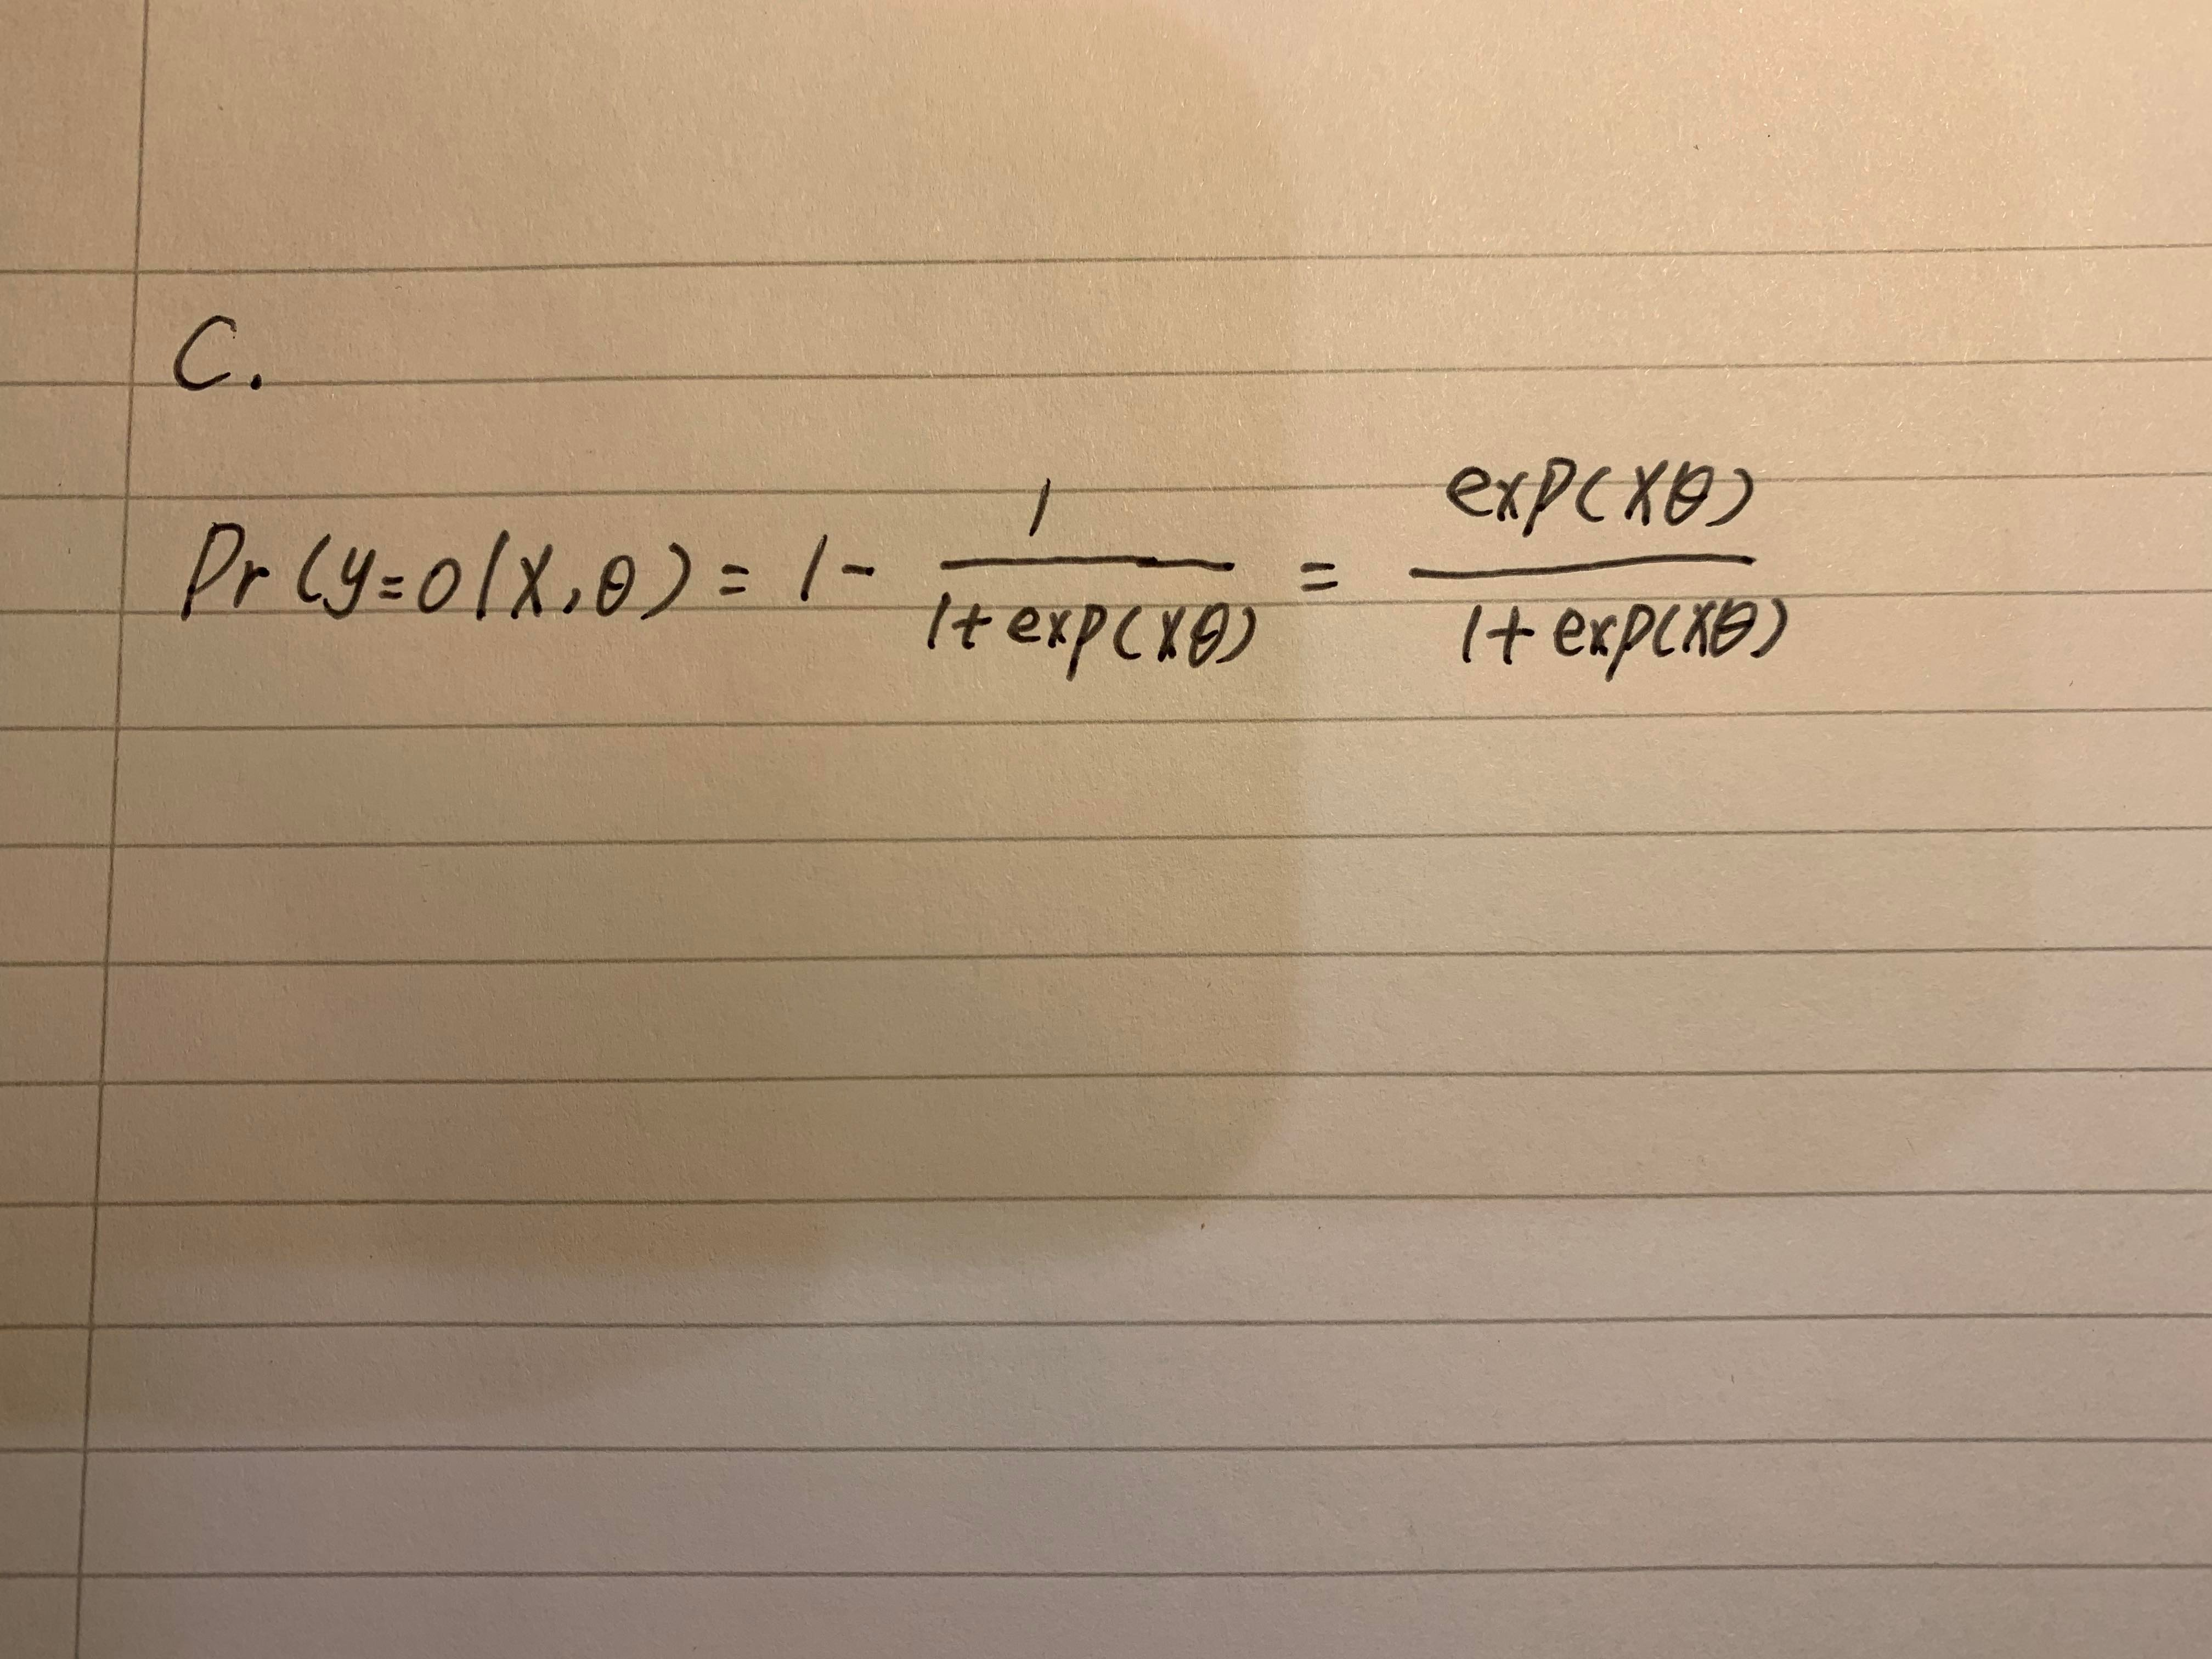

#### (d) Define p(X, θ) = 1/(1+exp(Xθ)). Show that we can write log Pr(y, X, θ) = y log(p(X, θ)) + (1 − y) log(1 − p(X, θ))

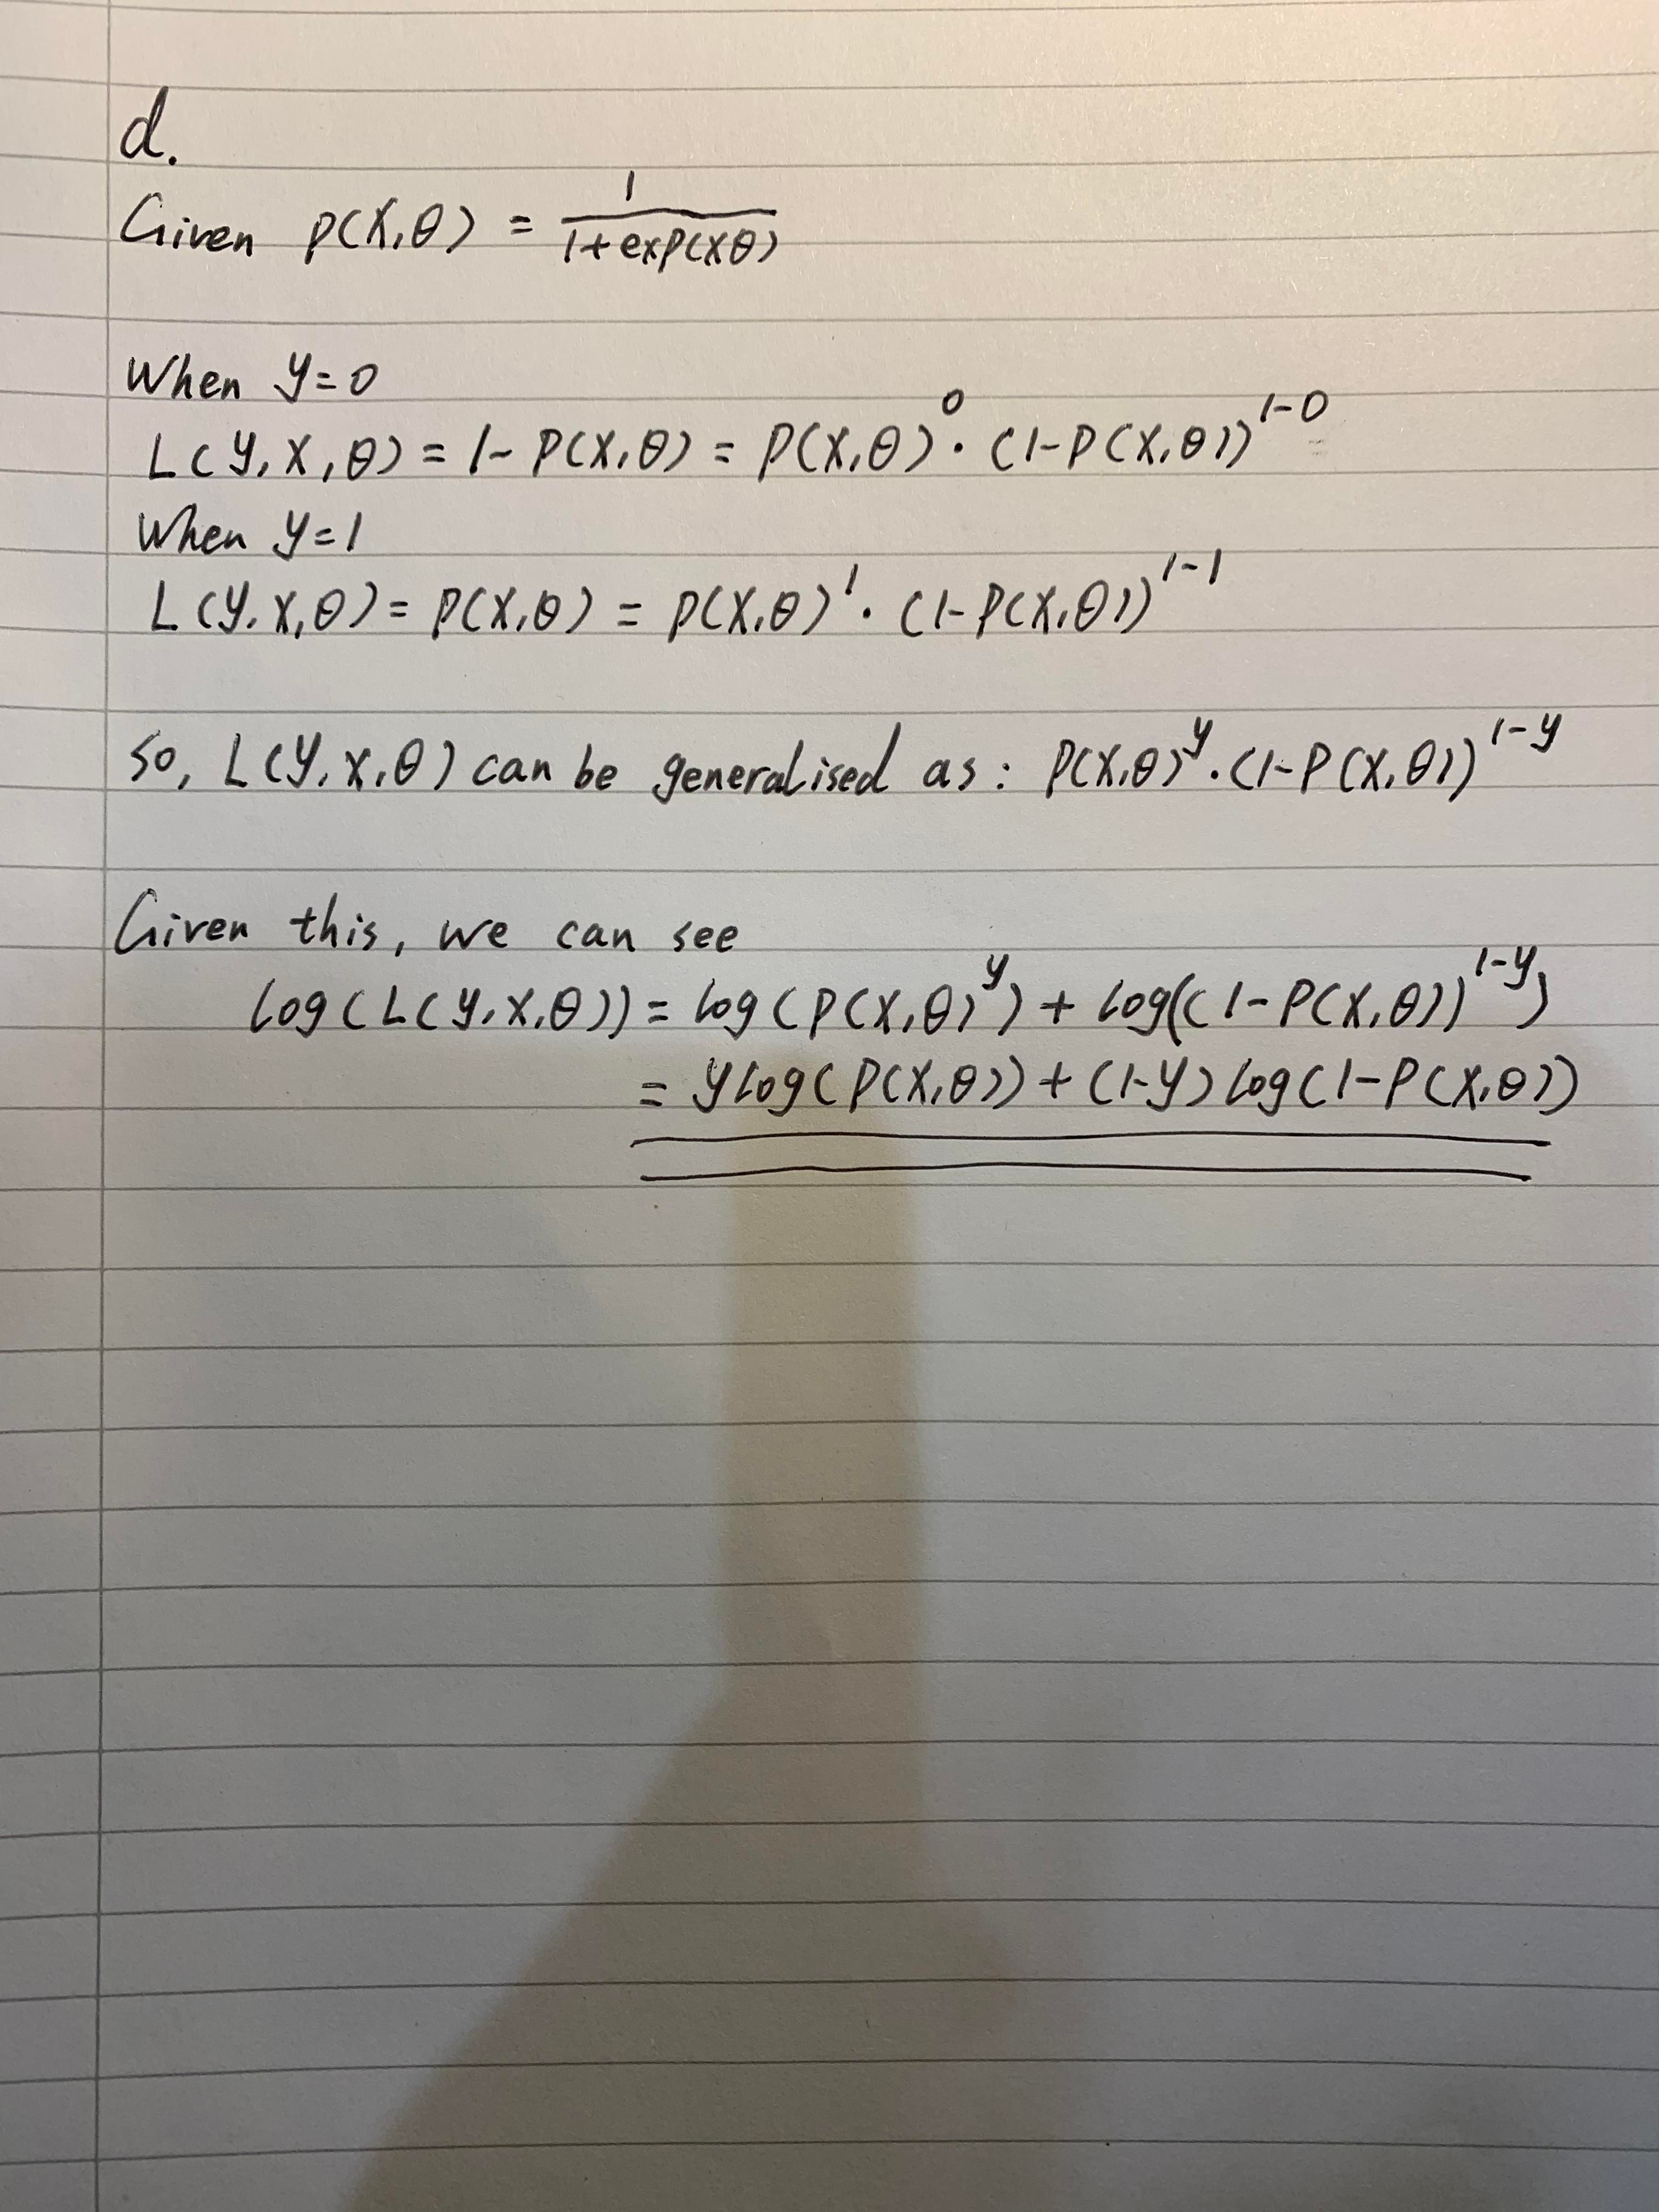

#### (e) Now find a formula for it’s gradient and it’s Hessian. 

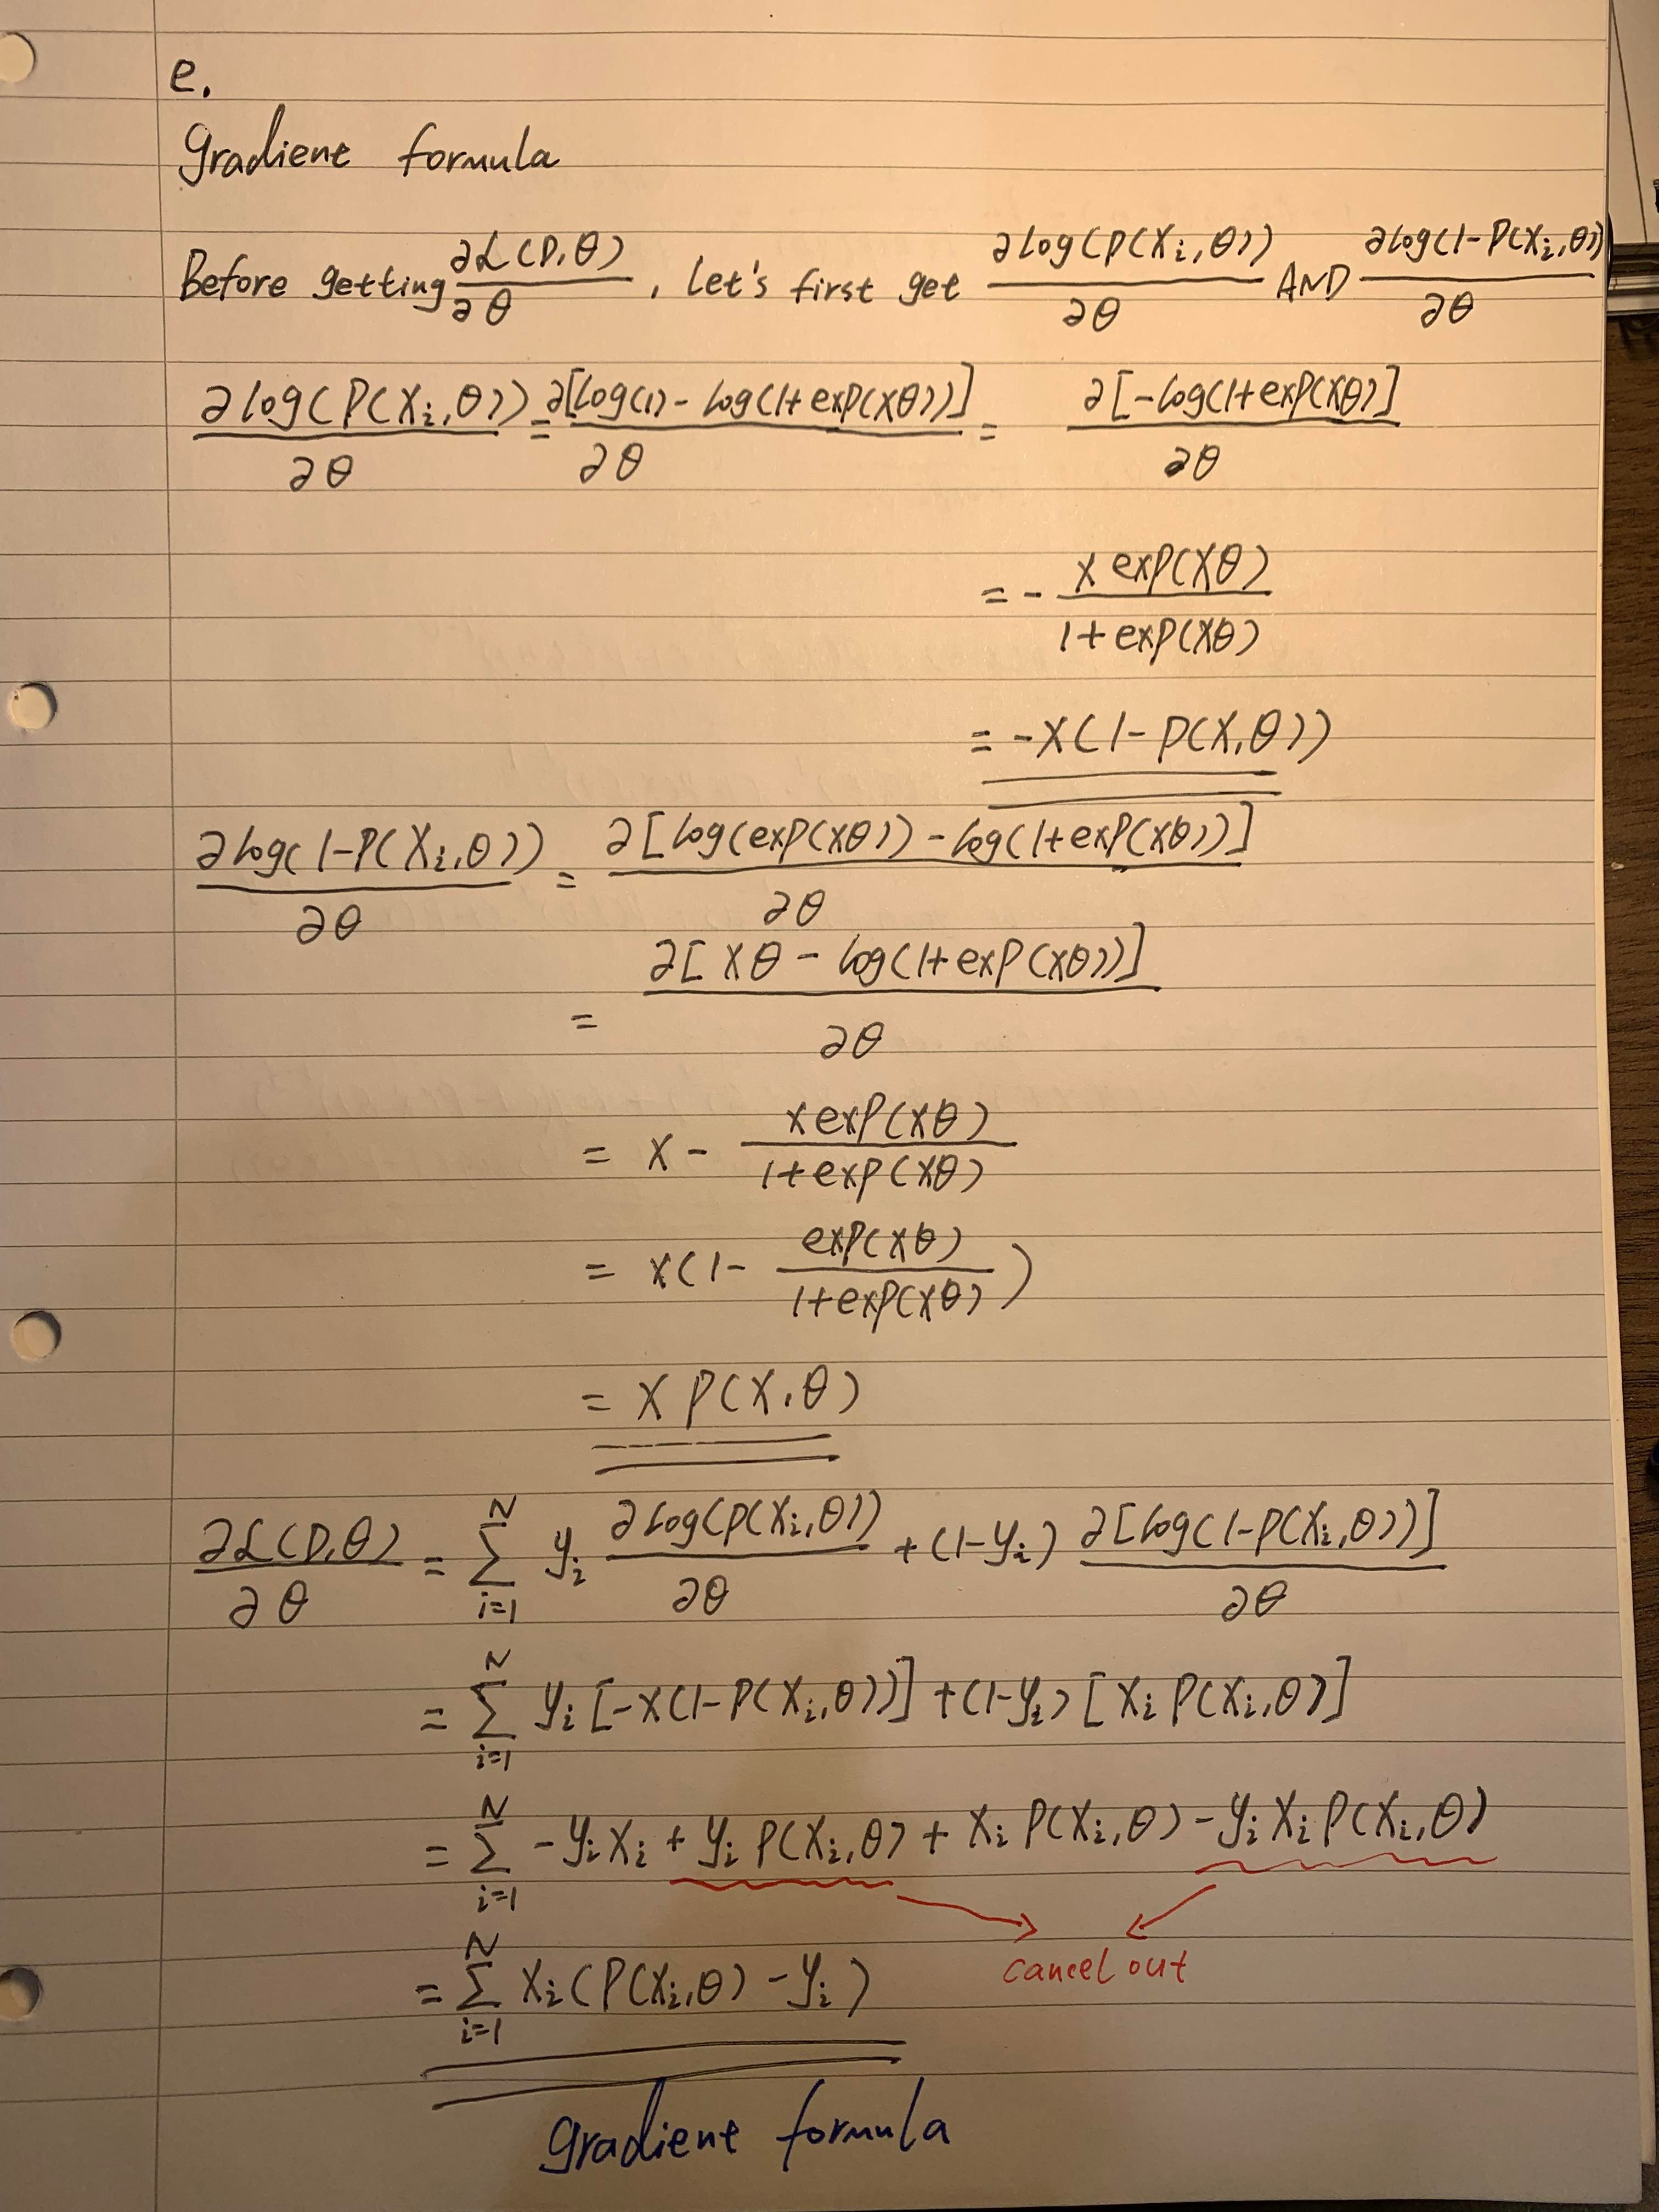


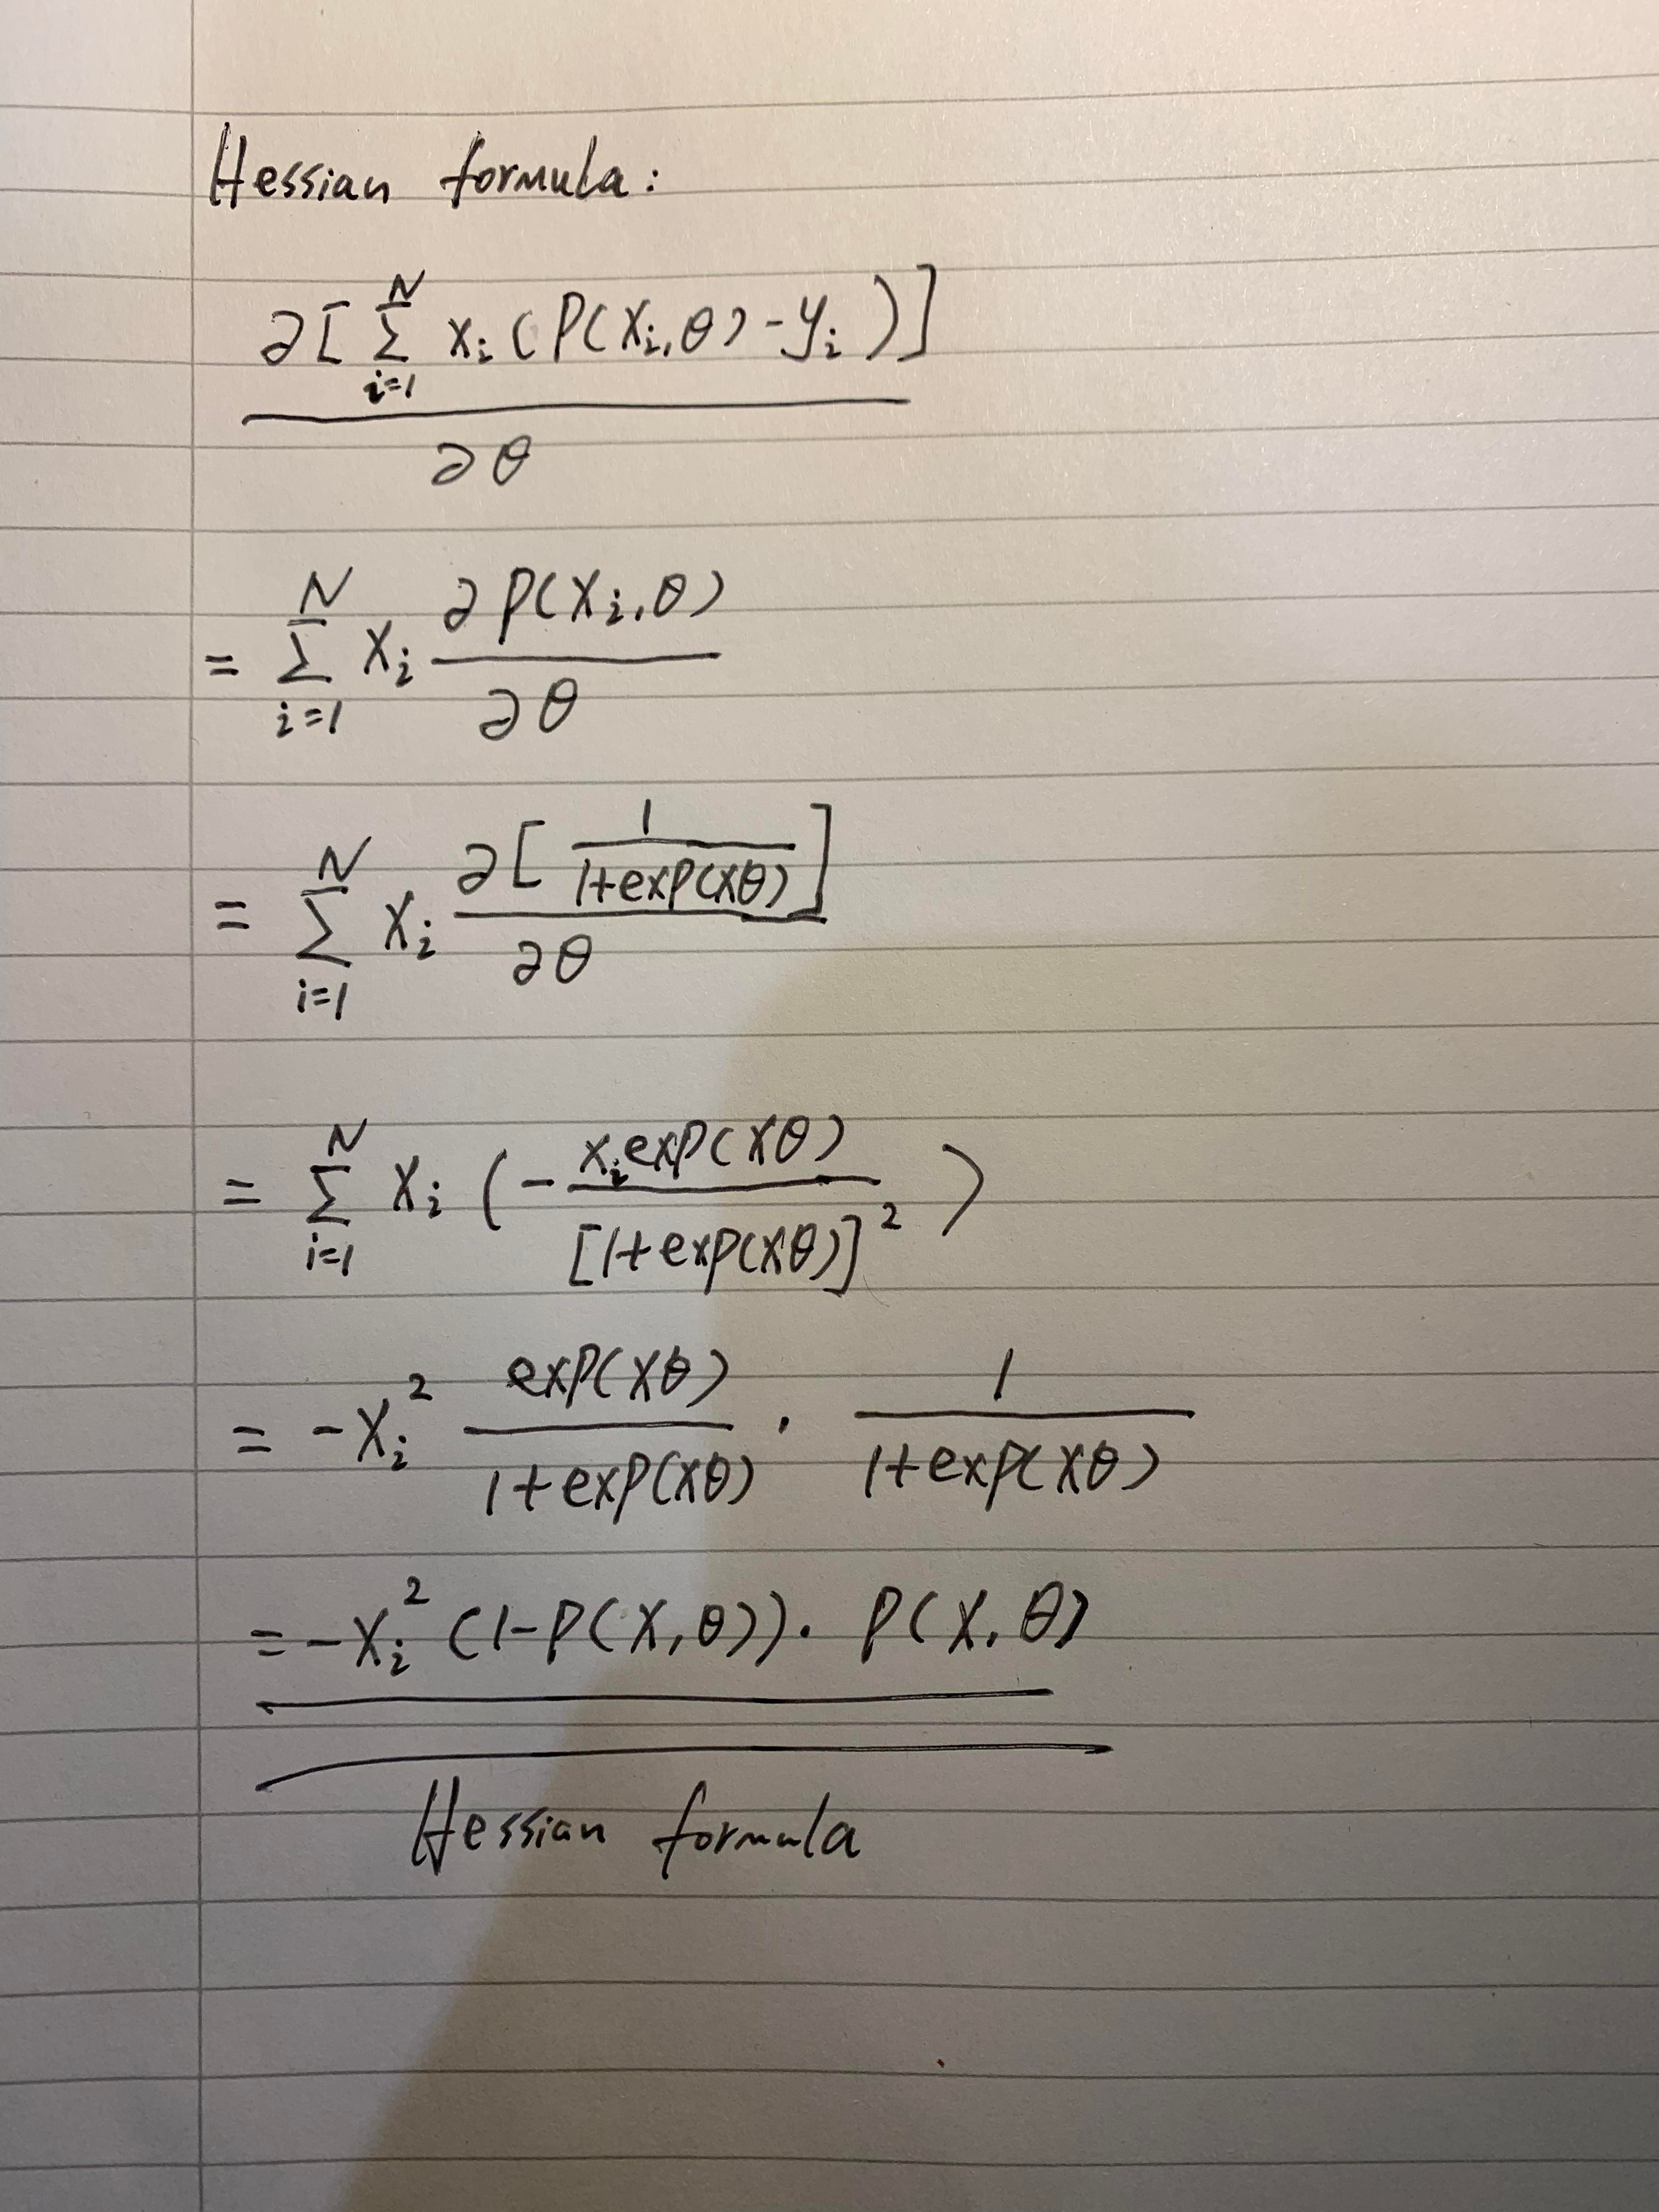

### Taking it to the data.

#### (f) Plot some things that look informative to you.

In [386]:
# Import data set 
os.chdir(r"C:\Users\icon8\Desktop\Programming for Economics\W6")
df = pd.read_csv(r'data.csv')
df

IQ    wage  childsupp welfare   race  tenure     sex  famsize  \
0    105  1282.0          0      NO  WHITE     162    MALE        3   
1    112  1081.0          0      NO  WHITE     523  FEMALE        2   
2    137    -4.0          0      NO  WHITE      -4  FEMALE        3   
3    114  1009.0          0      NO  WHITE     375  FEMALE        3   
4     90  1237.0          0      NO  WHITE     158  FEMALE        2   
..   ...     ...        ...     ...    ...     ...     ...      ...   
991   33   921.0          0      NO  WHITE     169  FEMALE        4   
992  116   750.0       1872      NO  WHITE      88  FEMALE        7   
993  105   800.0          0      NO  WHITE       9  FEMALE        3   
994  112  1081.0          0      NO  WHITE      32    MALE        2   
995   43  1808.0          0      NO  WHITE      18    MALE        2   

                empstat         region  marital      eduyrs  age  urban  \
0              EMPLOYED      NORTHEAST  MARRIED  12TH GRADE   28  URBAN   
1              EMPLOYED      NORTHEAST  MARRIED  2ND YR COL   29  URBAN   
2    OUT OF LABOR FORCE      NORTHEAST  MARRIED  4TH YR COL   29  RURAL   
3              EMPLOYED      NORTHEAST  MARRIED  12TH GRADE   30  RURAL   
4              EMPLOYED      NORTHEAST  MARRIED  12TH GRADE   26  URBAN   
..                  ...            ...      ...         ...  ...    ...   
991            EMPLOYED      NORTHEAST  MARRIED  12TH GRADE   28  URBAN   
992            EMPLOYED  NORTH CENTRAL  MARRIED  10TH GRADE   29  RURAL   
993            EMPLOYED  NORTH CENTRAL  MARRIED  2ND YR COL   27  RURAL   
994            EMPLOYED  NORTH CENTRAL  MARRIED  1ST YR COL   26  URBAN   
995            EMPLOYED  NORTH CENTRAL  MARRIED  6TH YR COL   25  URBAN   

       unemprate  
0    3.0 - 5.9\%  
1    3.0 - 5.9\%  
2        < 3.0\%  
3    3.0 - 5.9\%  
4    3.0 - 5.9\%  
..           ...  
991  3.0 - 5.9\%  
992  6.0 - 8.9\%  
993  6.0 - 8.9\%  
994  6.0 - 8.9\%  
995  6.0 - 8.9\%  

[996 rows x 15 columns]

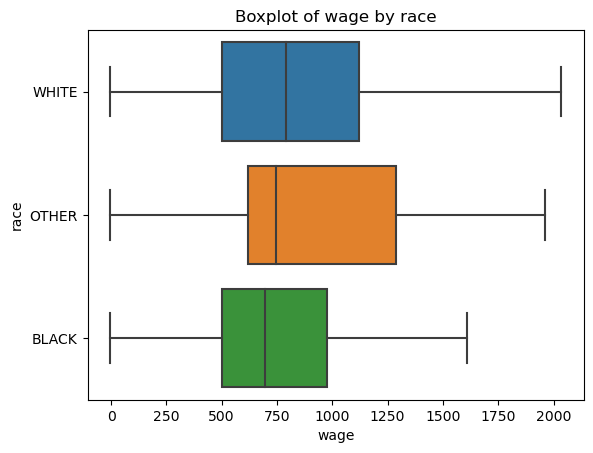

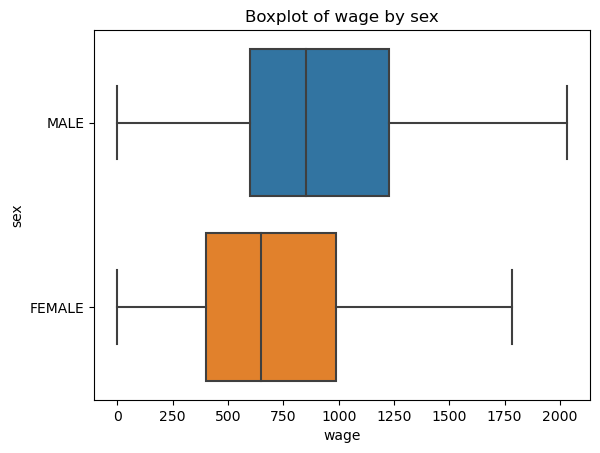

[Text(0.5, 1.0, 'Boxplot of wage by marital status')]

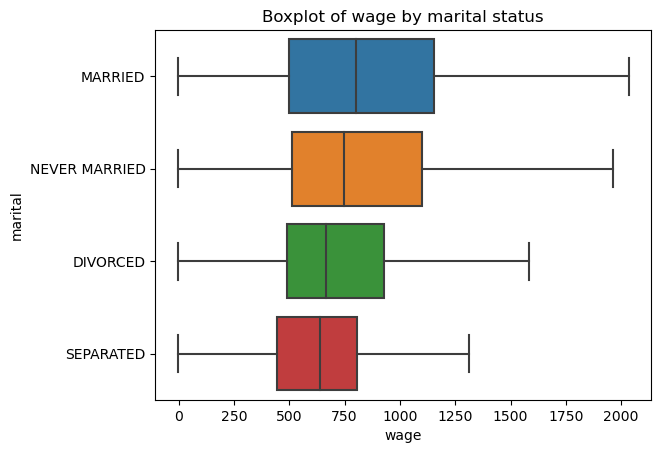

In [387]:
sns.boxplot(data=df, x="wage", y="race", showfliers = False).set(title='Boxplot of wage by race')
plt.show()
sns.boxplot(data=df, x="wage", y="sex", showfliers = False).set(title='Boxplot of wage by sex')
plt.show()
sns.boxplot(data=df, x="wage", y="marital", showfliers = False).set(title='Boxplot of wage by marital status')

#### (g)  Use your formula and try calculating the gradient and the Hessian of the data at several guesses for θ (you can always start with θ = 0). Benchmark your derivatives against either autodifferentiation or a finite differences implementation. Do you get the same results? If not, go back and check for errors.

To prepare the data, we one-hot encode each categorical variable into its corresponding dummies, and omit one from each category to avoid perfect multicollinearity. Then we regressed the data using the built in Logit model for future reference.

In [388]:
#We first run a logistic regression to later compare to thetas found by optimisation methods

# Create a copy of the data set
df1 = pd.read_csv(r'data.csv')

#create lists of variables for dummies we want to create
cat_vars = ['sex','race','marital','eduyrs','welfare','region','urban','unemprate']
y_var = ['empstat']

#Get dummies for data
df1 = pd.get_dummies(df1, columns=y_var)
df1 = pd.get_dummies(df1, columns=cat_vars)


#Outline variables to be dropped from dataset to conduct regression
#We also drop eduyrs 4th and 6th grade due to no observations
standard_vars = ['empstat_EMPLOYED','empstat_UNEMPLOYED', 'empstat_OUT OF LABOR FORCE', 'tenure', 'wage']
dummy_for_cat = ['sex_MALE', 'race_WHITE', 'marital_NEVER MARRIED', 'eduyrs_7TH GRADE', 'welfare_NO','region_NORTHEAST', 'urban_RURAL', 'unemprate_< 3.0\%','eduyrs_4TH GRADE', 'eduyrs_6TH GRADE']


# Drop one column from each of the dummies created not to encounted perfect collinearity
X1_vars = dummy_for_cat + standard_vars
X1 = df1.drop(columns = X1_vars, axis=1)


# Split the dataset into X and y

y = df1['empstat_EMPLOYED']

X1 = sm.add_constant(X1)

# Fit the logistic regression model to the data

log_reg = sm.Logit(y, X1)
result = log_reg.fit()

# Print the summary table of the logistic regression model
print(result.summary())



         Current function value: inf
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:       empstat_EMPLOYED   No. Observations:                  996
Model:                          Logit   Df Residuals:                      964
Method:                           MLE   Df Model:                           31
Date:                Thu, 09 Mar 2023   Pseudo R-squ.:                     inf
Time:                        14:25:55   Log-Likelihood:                   -inf
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         1.9602      1.753      1.118      0.263      -1.475       5.395
IQ                       

Next we proceed to manual gradient calculations.

In [389]:
#%% Gradient 
#We change our data into arrays
y = np.array(y)
X = np.array(X1)

#Input function for P(X,theta)
def logistic(x):
    return 1/(1+np.exp(x))

#Input the formula for the gradient
def log_likelihood_gradient(X,y,theta):
    p=logistic(X.dot(theta))
    gradient = -X.T.dot(p-y)
    return gradient

#Initialse guess
theta_init = np.zeros(32)
qe.tic()
grad = log_likelihood_gradient(X, y, theta_init)
qe.toc()
print(grad)

TOC: Elapsed: 0:00:0.00
[ 3.5600e+02  3.2199e+04  3.4089e+04  9.0450e+02  1.0001e+04  1.3550e+02
  7.5500e+01  7.0000e+00  2.5000e+01  1.8350e+02  1.6000e+01  7.5000e+00
  1.0500e+01  1.5600e+02  2.8500e+01  2.3000e+01  1.2000e+01  7.8000e+01
  1.4000e+01  1.1500e+01  3.5000e+00  3.5000e+00  3.5000e+00  6.0000e+00
 -3.0000e+00  8.0500e+01  1.4550e+02  3.0500e+01  2.6800e+02  2.6700e+02
  5.1000e+01  2.2500e+01]


In [406]:
#%% Hessian
#use same functions for log-like and logistic

# Define the Hessian matrix function
def hessian(theta, X):
    p=logistic(X.dot(theta))
    W = np.diag(p * (1 - p))
    return -X.T @ W @ X

# Initialize the parameter vector and compute the Hessian matrix
theta_0 = np.zeros(X.shape[1])
H = hessian(theta_0, X)

print("Hessian matrix:")
print(H)

Hessian matrix:
[[-2.49000000e+02 -2.20575000e+04 -2.51690000e+04 ... -1.77000000e+02
  -4.35000000e+01 -1.92500000e+01]
 [-2.20575000e+04 -2.15908050e+06 -2.29255200e+06 ... -1.59027500e+04
  -3.66400000e+03 -1.73300000e+03]
 [-2.51690000e+04 -2.29255200e+06 -8.62006495e+07 ... -1.79170000e+04
  -5.81700000e+03 -1.43500000e+03]
 ...
 [-1.77000000e+02 -1.59027500e+04 -1.79170000e+04 ... -1.77000000e+02
   0.00000000e+00  0.00000000e+00]
 [-4.35000000e+01 -3.66400000e+03 -5.81700000e+03 ...  0.00000000e+00
  -4.35000000e+01  0.00000000e+00]
 [-1.92500000e+01 -1.73300000e+03 -1.43500000e+03 ...  0.00000000e+00
   0.00000000e+00 -1.92500000e+01]]


In [391]:
#%% benchmarking using finite differences

#Gradient

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Define the log-likelihood function
def log_likelihood(theta, X, y):
    h = sigmoid(X @ theta)
    return np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))

# Define a function to compute the numerical gradient
def numerical_grad(fun, x, h=1e-6):
    grad = np.zeros_like(x)
    for i in range(len(x)):
        x_plus_h = np.copy(x)
        x_plus_h[i] += h
        x_minus_h = np.copy(x)
        x_minus_h[i] -= h
        grad[i] = (fun(x_plus_h) - fun(x_minus_h)) / (2 * h)
    return grad



theta = np.zeros(X.shape[1])
qe.tic() 
# Compute the gradient using finite differences
grad_loglik_fd = numerical_grad(lambda t: log_likelihood(t, X, y), theta)

qe.toc()
# Compare the two gradients

print("Finite differences gradient:", grad_loglik_fd)
print(grad)

TOC: Elapsed: 0:00:0.00
Finite differences gradient: [ 3.56000000e+02  3.21990000e+04  3.40890000e+04  9.04500000e+02
  1.00010000e+04  1.35500000e+02  7.55000000e+01  7.00000010e+00
  2.49999999e+01  1.83500000e+02  1.60000000e+01  7.50000004e+00
  1.05000000e+01  1.56000000e+02  2.85000000e+01  2.30000000e+01
  1.20000000e+01  7.80000000e+01  1.40000000e+01  1.15000000e+01
  3.49999999e+00  3.50000005e+00  3.49999999e+00  5.99999998e+00
 -2.99999999e+00  8.05000000e+01  1.45500000e+02  3.05000000e+01
  2.68000000e+02  2.67000000e+02  5.10000000e+01  2.25000000e+01]
[ 3.5600e+02  3.2199e+04  3.4089e+04  9.0450e+02  1.0001e+04  1.3550e+02
  7.5500e+01  7.0000e+00  2.5000e+01  1.8350e+02  1.6000e+01  7.5000e+00
  1.0500e+01  1.5600e+02  2.8500e+01  2.3000e+01  1.2000e+01  7.8000e+01
  1.4000e+01  1.1500e+01  3.5000e+00  3.5000e+00  3.5000e+00  6.0000e+00
 -3.0000e+00  8.0500e+01  1.4550e+02  3.0500e+01  2.6800e+02  2.6700e+02
  5.1000e+01  2.2500e+01]


The finite differences method returns the same gradient values as manual calculation.

In [393]:
#%% Hessian using Finite Differences
# Define a function to compute the numerical Hessian
def numerical_hessian(fun, x, h=1e-1):
    n = len(x)
    hess = np.zeros((n, n))
    f = fun(x)
    for i in range(n):
        x_plus_h = np.copy(x)
        x_plus_h[i] += h
        f_plus_h = fun(x_plus_h)
        for j in range(n):
            x_plus_h_j = np.copy(x_plus_h)
            x_plus_h_j[j] += h
            f_plus_h_j = fun(x_plus_h_j)
            hess[i, j] = (f_plus_h_j - f_plus_h + f - fun(x_plus_h_j)) / h**2
        hess[i, i] = (fun(x_plus_h) - 2 * f + fun(x_plus_h - h)) / h**2
    return hess


# Compute the Hessian using finite differences
hess_loglik_fd = numerical_hessian(lambda t: log_likelihood(t, X, y), theta)


print("Finite differences Hessian:", hess_loglik_fd)




Finite differences Hessian: [[-1.83935583e+06 -3.43555184e+03             nan ... -3.43555184e+03
  -3.43555184e+03 -3.43555184e+03]
 [ 5.10742931e+04 -1.14169013e+06             nan ...  5.10742931e+04
   5.10742931e+04  5.10742931e+04]
 [            nan             nan             nan ...             nan
              nan             nan]
 ...
 [-2.58153685e+03 -2.58153685e+03             nan ... -1.84253876e+06
  -2.58153685e+03 -2.58153685e+03]
 [-4.88259056e+02 -4.88259056e+02             nan ... -4.88259056e+02
  -1.84946089e+06 -4.88259056e+02]
 [-2.15379008e+02 -2.15379008e+02             nan ... -2.15379008e+02
  -2.15379008e+02 -1.85050351e+06]]


In case of the hessian we ran into some issues which led to different values of the matrix than the manual method. We tried changing h=1e-1 to different values, but found that the smaller this value was the hessian starting moving towards infinity. Unfortunately we were not able to figure out why this was.

#### (h) Use your preferred optimization routine to solve for the value of θ which maximizes the log-likelihood and report the values.

In [333]:
#%% h 

# For this part we will use Newton's method

# Define the logistic function and its gradient
def logistic(x):
    return 1/(1 + np.exp(-x))

# Define the log-likelihood function and its gradient
def log_likelihood(theta, X, y):
    p = logistic(X @ theta)
    return np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

def log_likelihood_grad(theta, X, y):
    p = logistic(X @ theta)
    return X.T @ (p - y)

# Define the Hessian matrix
def hessian(theta, X):
    p = logistic(X @ theta)
    W = np.diag(p * (1 - p))
    return X.T @ W @ X

# Initialize the parameter vector and other variables
theta = np.zeros(X.shape[1])
max_iter = 100
tolerance = 1e-6

# Run the Newton's method algorithm
for i in range(max_iter):
    grad = log_likelihood_grad(theta, X, y)
    hess = hessian(theta, X)
    step = np.linalg.inv(hess) @ grad
    theta_new = theta - step
    loglik_old = log_likelihood(theta, X, y)
    loglik_new = log_likelihood(theta_new, X, y)
    if np.abs(loglik_new - loglik_old) < tolerance:
        break
    theta = theta_new

# Print the results
print("Estimated parameter values:", theta)
theta_newton = theta

#We get roughly the same theta values as for the automatic logistic regression.


Estimated parameter values: [ 1.96044284e+00  1.04954211e-03  3.85583008e-04 -3.66122526e-01
 -1.14654910e-02 -1.69975000e+00 -2.89308668e-01 -1.93494208e-01
 -6.40183249e-01 -2.00404533e-01  5.02943647e-01  1.76320804e+00
  2.07216876e+00  2.32502251e+00  2.65302882e+00  2.84721546e+00
  2.38718106e+00  2.79628206e+00  3.65854603e+00  1.74243418e+01
  2.25014061e+00  1.51732111e+00  1.68704617e+01  1.88954102e+00
 -1.61958077e+00  1.44838914e-02  2.89668820e-01 -5.74652987e-01
  3.53899898e-01  3.66198009e-02 -3.90360656e-01 -3.72966757e-01]


#### (i) Try it with several other algorithms (make sure you use Newton’s Method, L-BGFGS, and NelderMead). Restart it several times from different initial conditions. Do you converge to the same answer?

In [337]:
#%% i L- BFGS

# define log-likelihood function
def log_likelihood(theta, X, y):
    p = 1/(1+np.exp(-X.dot(theta)))
    log_l = np.sum(y*np.log(p) + (1-y)*np.log(1-p))
    return -log_l

# define gradient of log-likelihood function
def log_likelihood_grad(theta, X, y):
    p = 1/(1+np.exp(-X.dot(theta)))
    grad = np.sum((p - y)[:, np.newaxis] * X, axis=0)
    return -grad

# define initial guess
theta_0 = np.full(X.shape[1], 0)

# minimize negative log-likelihood using L-BFGS-B
result = minimize(log_likelihood, theta_0, args=(X, y), method='L-BFGS-B', jac=log_likelihood_grad)

# print optimized values of theta
print(result.x)
theta_BFGS = result.x

#The L-BFGS keeps outputting the guess regardless of the initial guess

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [338]:
#%% Nelder-Mead

def logistic(x):
    return 1 / (1 + np.exp(-x))

def log_likelihood(theta, X, y):
    p = logistic(X @ theta)
    return np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))


# Define the objective function to be minimized
def objective(theta):
    return -log_likelihood(theta, X, y)

# Set the initial guess
theta_0 = np.full(X.shape[1], 0)

# Minimize the objective function using the Nelder-Mead algorithm
result = minimize(objective, theta_0, method='Nelder-Mead')

# Print the results
print("Optimal theta values:", result.x)
theta_NM = np.array(result.x)

#Provides an estimation for each theta but it is different than for Newton and the Logistic Regression

Optimal theta values: [-6.37427742e-01  5.31852623e-03  1.06265910e-04 -4.53320950e-01
  1.06567590e-01 -2.15619348e-01  8.10308499e-02  2.86117627e-01
 -5.72093394e-01 -2.06516156e-01  2.15178270e-02  4.06529900e-01
  2.56056046e-01 -1.16237614e-02  3.78441428e-01  1.86434302e-01
  1.10299638e-01 -1.06555917e-01  1.35852177e-01 -1.03919748e-01
 -3.74488514e-01 -2.05919692e-01  1.91355284e-01  1.26513264e-01
 -5.56575372e-01  3.08044375e-01  1.23722381e-01 -4.88075877e-01
  3.39392981e-01  5.41088524e-01 -2.63163255e-02  1.40271878e-01]


In [339]:
#%%Powell
def log_likelihood(theta, X, y):
    p = 1/(1+np.exp(-X.dot(theta)))
    log_l = np.sum(y*np.log(p) + (1-y)*np.log(1-p))
    return -log_l

# define gradient of log-likelihood function
def log_likelihood_grad(theta, X, y):
    p = 1/(1+np.exp(-X.dot(theta)))
    grad = np.sum((p - y)[:, np.newaxis] * X, axis=0)
    return -grad

# define initial guess
theta_0 = np.full(X.shape[1], 0)

# minimize negative log-likelihood using L-BFGS-B
result = minimize(log_likelihood, theta_0, args=(X, y), method='Powell')

# print optimized values of theta
print(result.x)
theta_powell = result.x

# Values quite similar to Newton's method but still not the same

[4.37482075 5.17585792 5.17585792 5.17585792 5.17585792 5.17585792
 5.17585792 5.17585792 5.17585792 5.17585792 5.17585792 5.17585792
 5.17585792 5.17585792 5.17585792 5.17585792 5.17585792 5.17585792
 5.17585792 5.17585792 5.17585792 5.17585792 5.17585792 5.17585792
 5.17585792 5.17585792 5.17585792 5.17585792 5.17585792 5.17585792
 5.17585792 5.17585792]


In the end it turns out that none of the methods provide the same theta estimates. Nelder-Mead and Powell are relatively close in terms of order of magnitude, while BFGS just keeps reporting the guess. 

#### (j) Make a plot of the objective function around your estimated parameter values. Do your parameterslook well-identified? How can you tell? Is there a more formal check you can do?

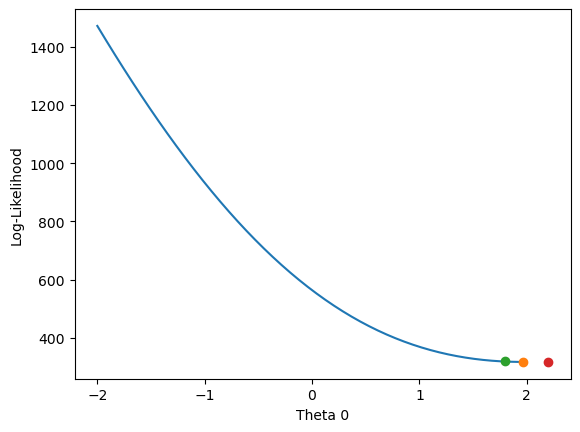

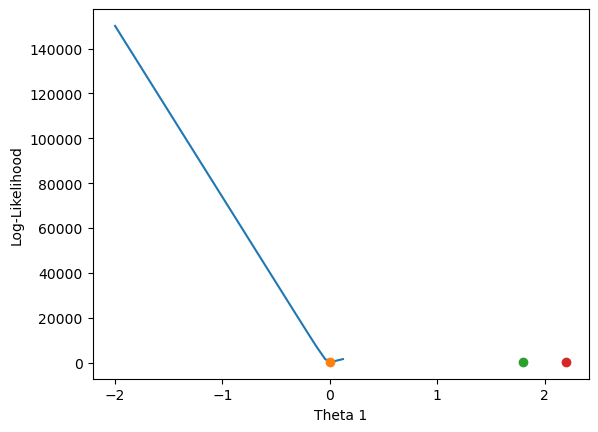

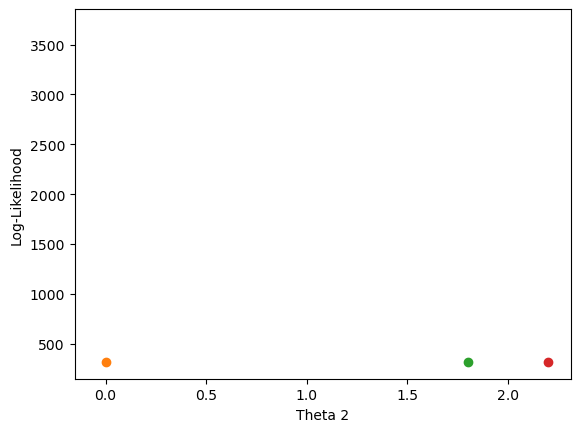

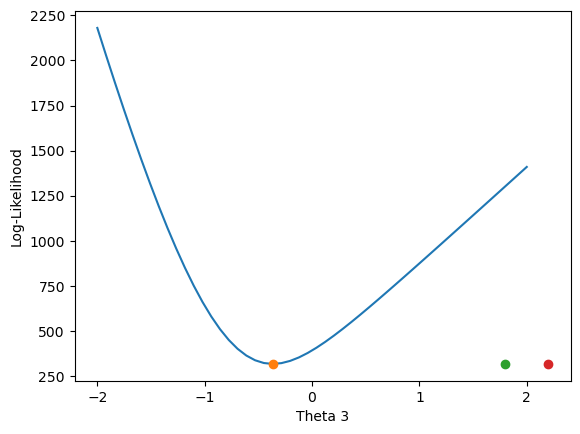

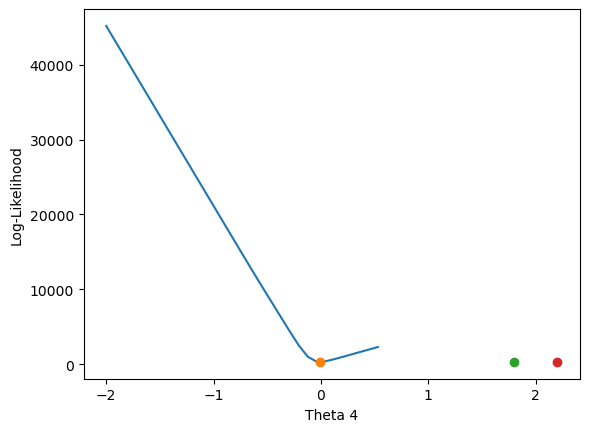

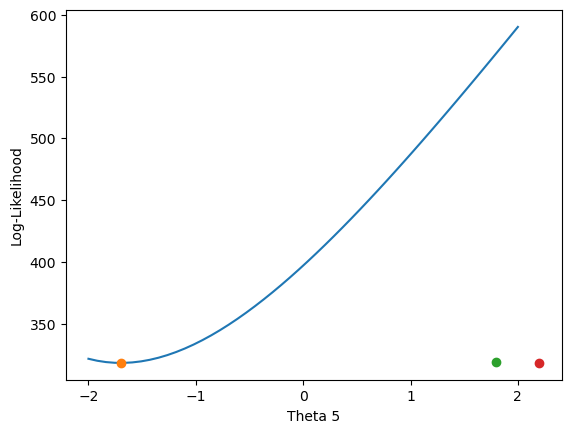

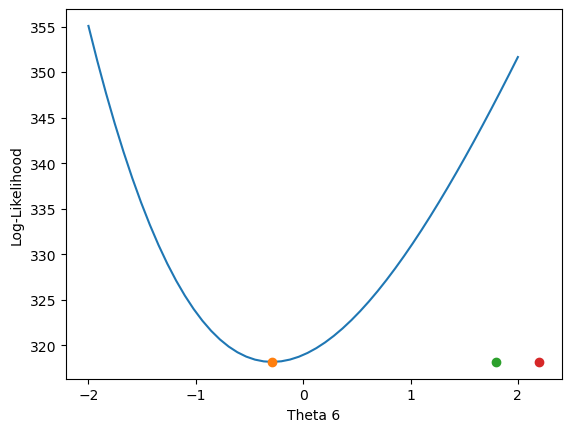

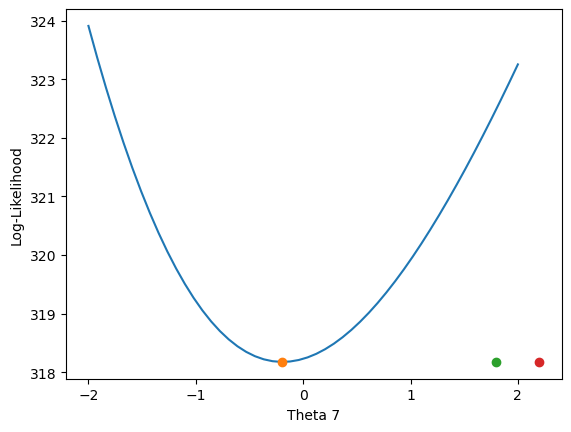

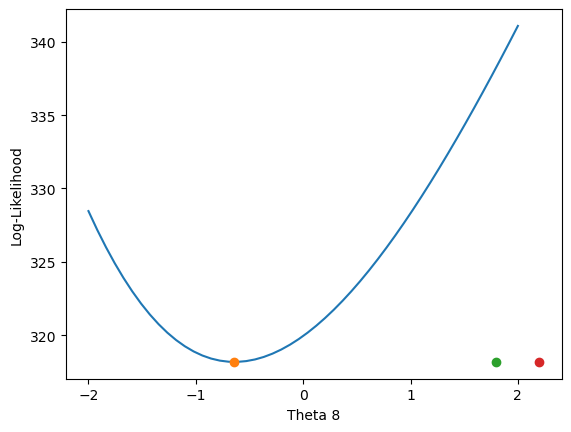

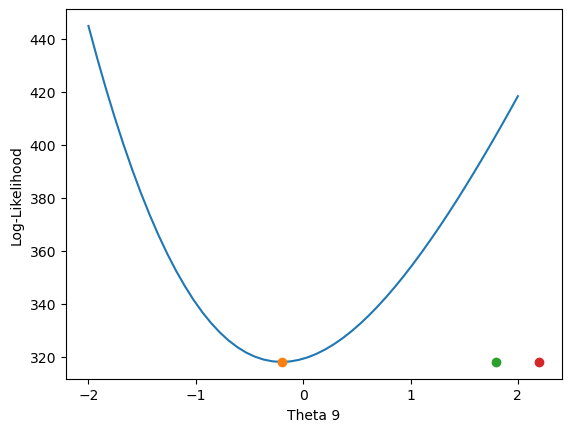

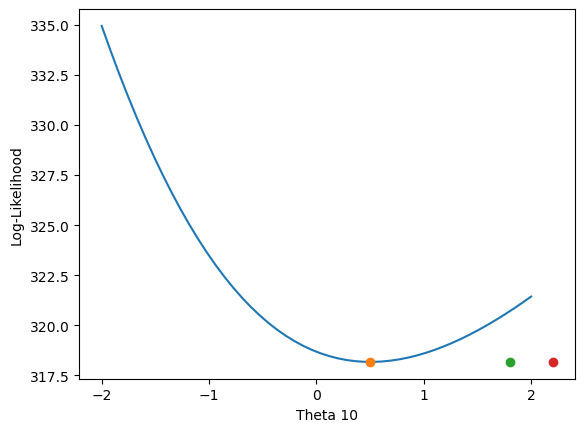

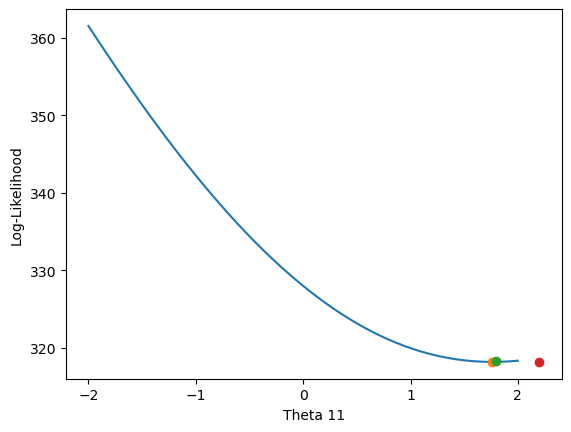

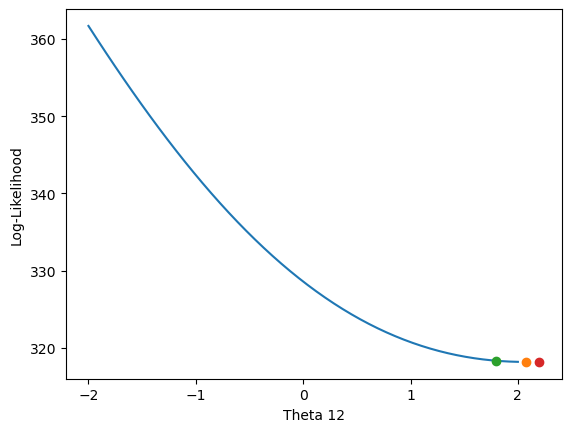

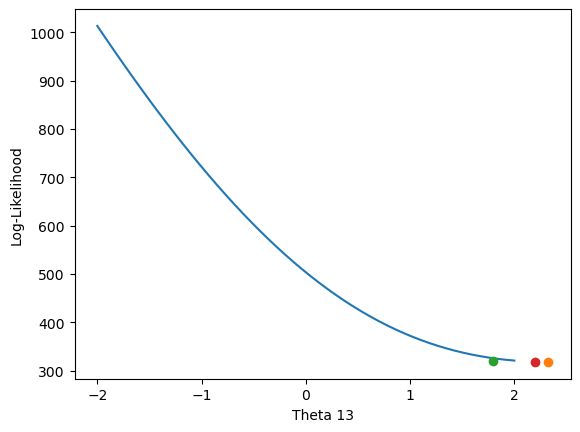

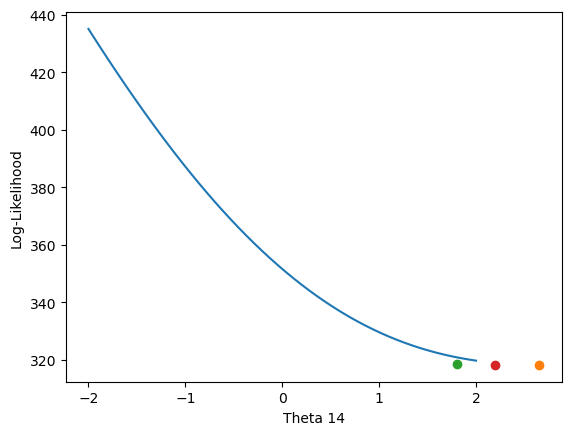

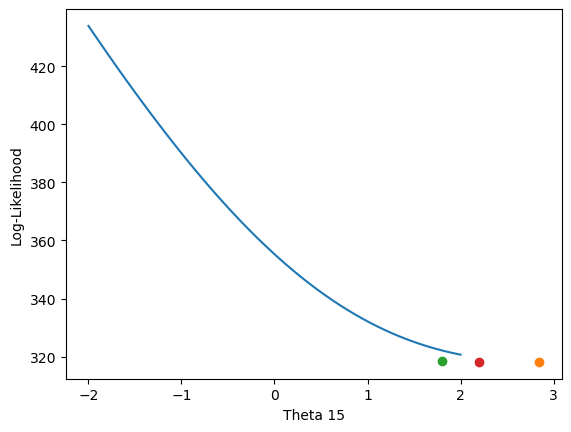

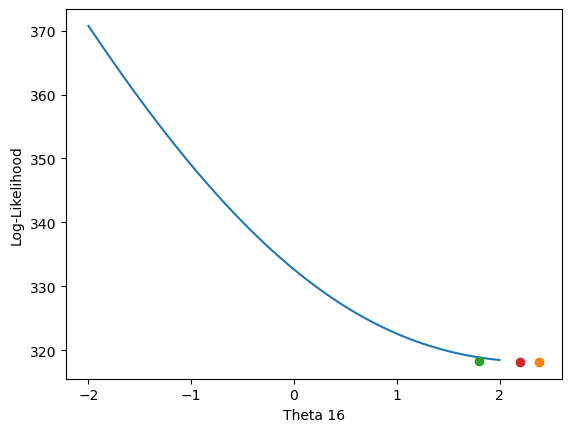

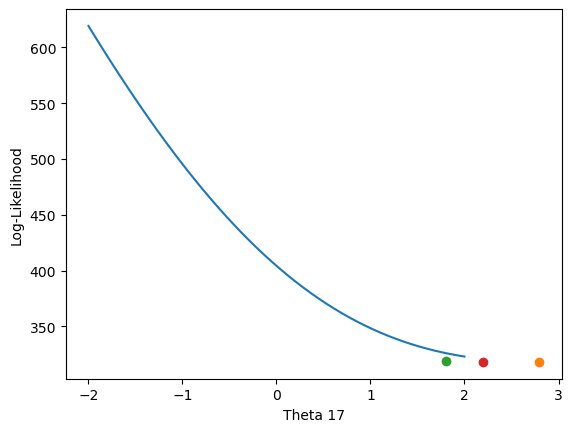

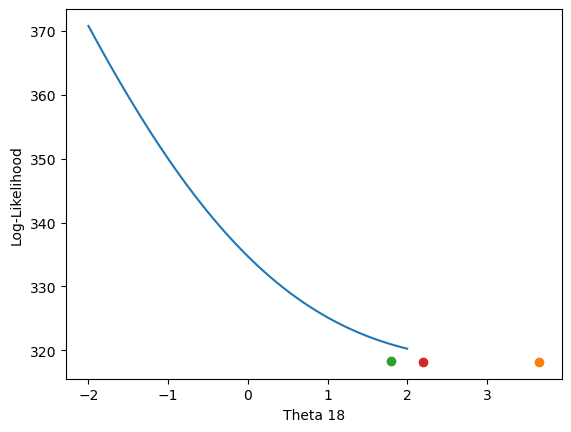

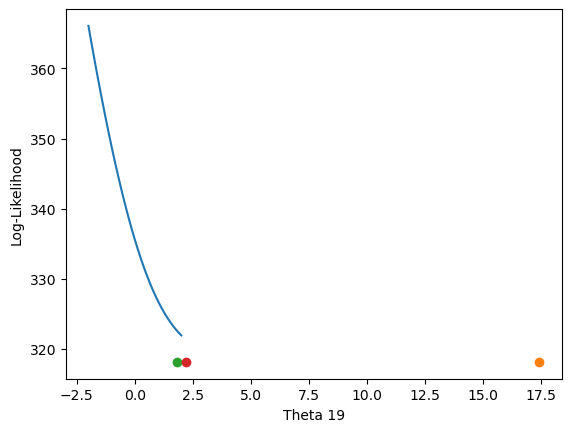

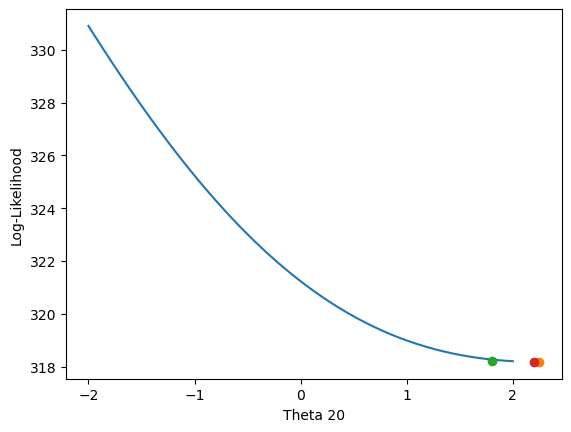

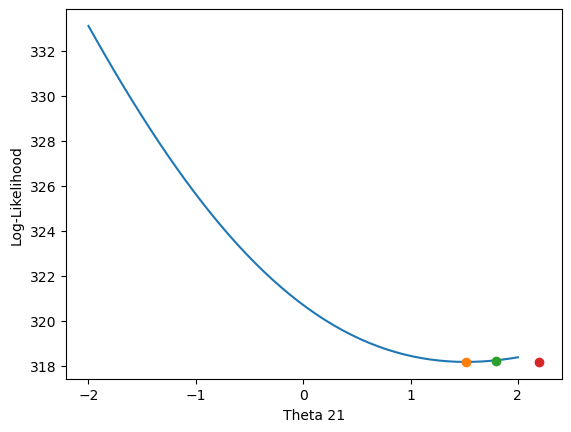

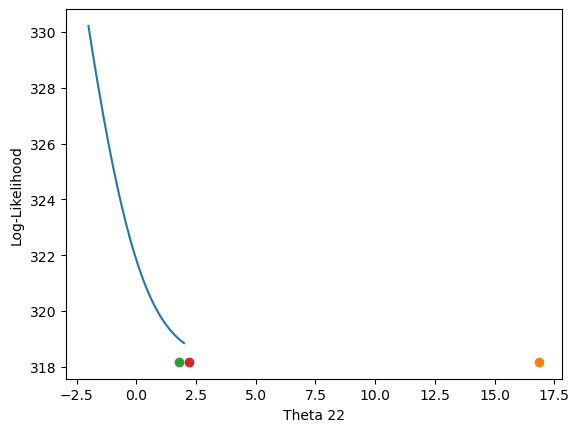

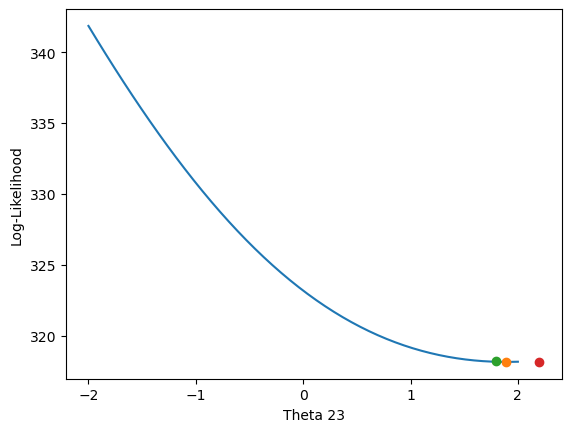

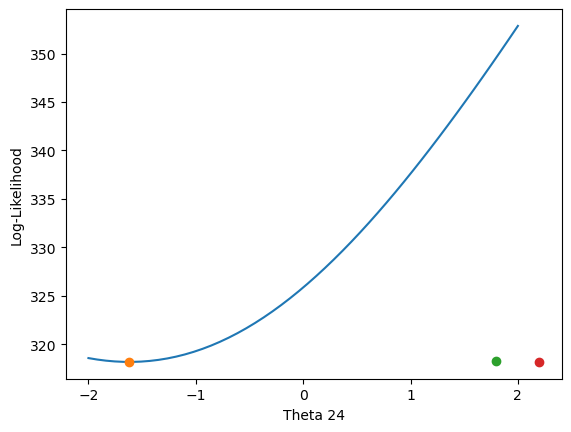

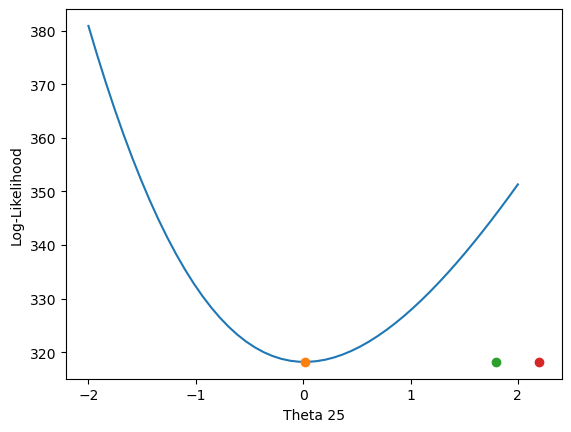

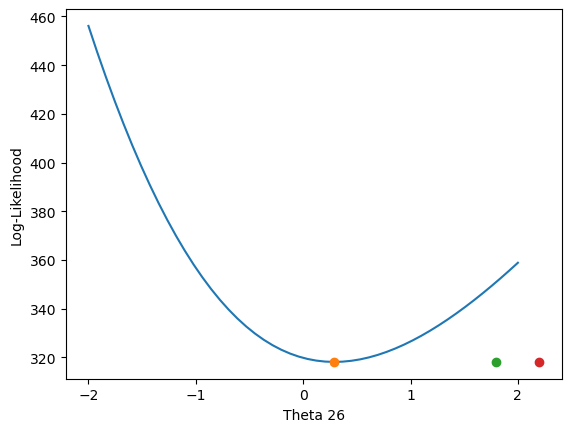

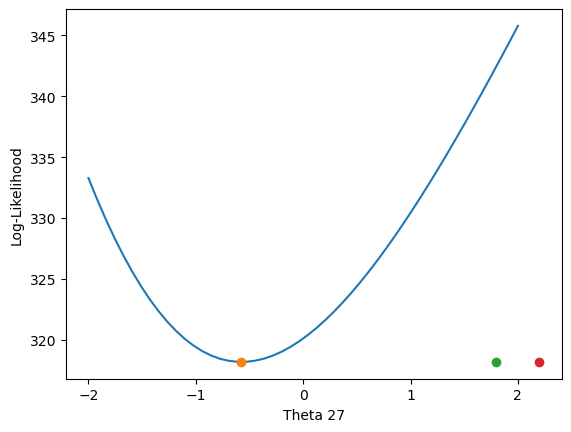

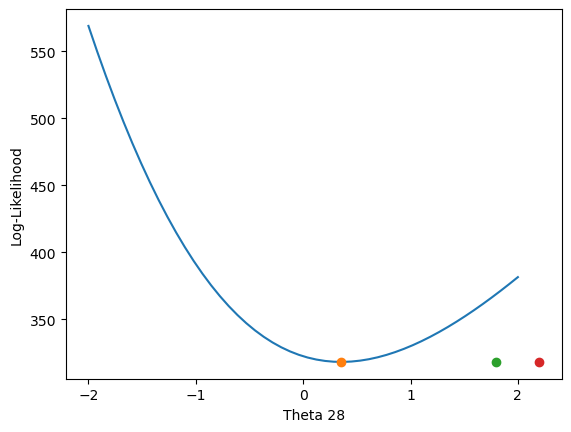

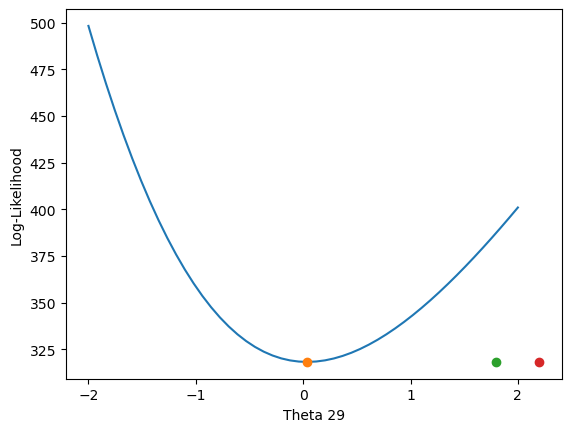

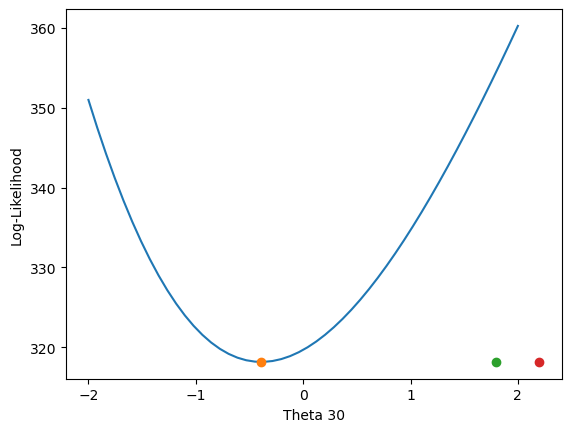

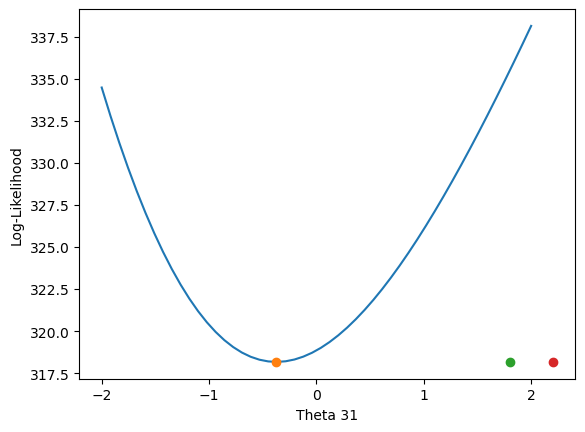

In [340]:

# Generate a grid of values to plot the objective function over
n_points = 50
theta_grid = np.linspace(-2, 2, n_points)

# Iterate through each theta parameter
for i in range(len(theta_newton)):
    theta_temp = np.copy(theta_newton)
    theta_temp[i] *= 0.9 # Subtract 10%
    ll_minus = log_likelihood(theta_temp, X, y)
    theta_temp[i] *= 1.1 # Add 10%
    ll_plus = log_likelihood(theta_temp, X, y)
    ll_grid = np.zeros(n_points)
    for j in range(n_points):
        theta_temp[i] = theta_grid[j]
        ll_grid[j] = log_likelihood(theta_temp, X, y)

    # Create a plot of the objective function for this parameter
    plt.plot(theta_grid, ll_grid)
    plt.plot(theta_newton[i], log_likelihood(theta_newton, X, y), 'o')
    plt.plot(theta_temp[i]*0.9, ll_minus, 'o')
    plt.plot(theta_temp[i]*1.1, ll_plus, 'o')
    plt.xlabel('Theta {}'.format(i))
    plt.ylabel('Log-Likelihood')
    plt.show()



The orange circle indicates the estimated theta and for most plots it is at the minimum point, for some theta it 
appears not to have converged and the orange circle is outside the plotted function. Overall it appears that parameters are identified properly. Nonetheless it would be potentially helpful to run some more formal checks such as the Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC).
